# Análise da performance olímpica dos países sede: sediar a olímpiada melhora o desempenho da nação?


## Introdução

Nesta análise detalhada dos quadros de medalhas olímpicos, nosso objetivo é investigar a relação entre sediar os Jogos Olímpicos e o desempenho dos países. Inspirados pelo livro "Storytelling with Data", vamos explorar os dados das Olimpíadas com ênfase na visualização eficaz dos dados e na narrativa impactante. Dividindo as medalhas em bronze, prata e ouro, vamos analisar como o país anfitrião influencia o resultado final, utilizando os princípios do storytelling para comunicar nossas descobertas de forma clara e convincente.

### Dados

Para as análises foram usados os seguintes datasets:

[120 years of Olympic history: athletes and results](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results)

[Population by Country - 2020](https://www.kaggle.com/datasets/tanuprabhu/population-by-country-2020/data)

[2021 Olympics in Tokyo](https://www.kaggle.com/datasets/arjunprasadsarkhel/2021-olympics-in-tokyo/data)

[Olympic Games 2021 Medals](https://www.kaggle.com/datasets/stefanzivanov/olympic-games-2021-medals)


### Referências e Inspirações


As incríveis visualizações de dados de Cedric Scherer:

https://www.cedricscherer.com/

Galeria de Python:

https://www.python-graph-gallery.com/






In [14]:
import numpy as np
import pandas as pd

import folium
from folium import plugins
import geopandas as gpd
import branca

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import ttest_ind

# Config parametros do matplotlib
plt.rcParams["font.family"] = "monospace"
plt.rcParams['figure.dpi'] = 150
background_color='#F5F4EF'



In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
caminho = '/content/drive/MyDrive/dados/olympics'

In [17]:
populacao = pd.read_csv(f'{caminho}/population_by_country_2020.csv')
regiao = pd.read_csv(f'{caminho}/noc_regions.csv')

df = pd.read_csv(f'{caminho}/athlete_events.csv')
df_21 = pd.read_csv(f'{caminho}/Tokyo_2021_dataset_v4.csv')
df_21_full = pd.read_csv(f'{caminho}/Tokyo_2021_dataset_v4.csv')


# Para o gráfico em mapa
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
paises_formatado = f'{url}/world-countries.json'

In [18]:
import warnings
warnings.filterwarnings("ignore")

## Tokyo 2021


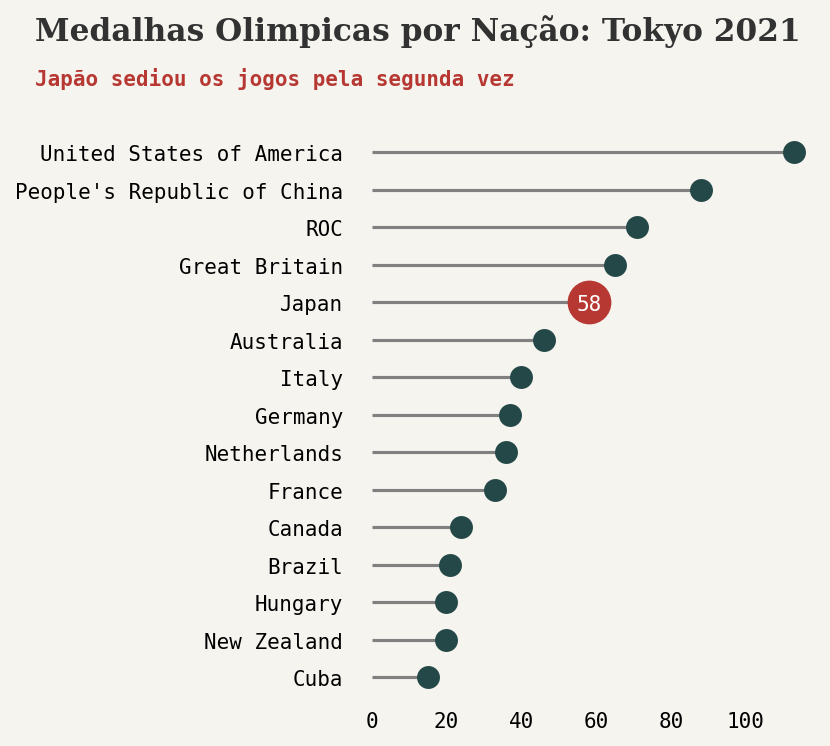

In [19]:
fig, ax = plt.subplots(figsize=(4, 5), facecolor=background_color)

# Selecionando os top 15 medalhistas
temp = df_21_full[:15].sort_values(by = 'Total')
top15_paises = range(1, len(df_21_full[:15]['Team/NOC']) + 1)
ax.set_facecolor(background_color)

# Traçando as linhas horizontais e os pontos
plt.hlines(y = top15_paises, xmin = 0, xmax = temp['Total'], color = 'gray')
plt.plot(temp['Total'], top15_paises, "o", markersize = 10, color = '#244747')
plt.plot(temp['Total'][2], top15_paises[10], "o", markersize = 20, color = '#B73832')


x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Total Medals",fontfamily='monospace',loc='left',color='gray')
ax.set_axisbelow(True)

# Retirando bordas do gráfico
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)


# Adicionando titulos e subtitulos
ax.text(-90, y_final + 2.3, 'Medalhas Olimpicas por Nação: Tokyo 2021', fontsize = 15, fontweight = 'bold', fontfamily = 'serif', color = '#323232')
ax.text(-90, y_final + 1.1, 'Japão sediou os jogos pela segunda vez', fontsize = 10, fontweight = 'bold', color = '#B73832')
plt.yticks(top15_paises, temp['Team/NOC'])
plt.xlabel('')

# Adicionando total de medalhas do Japão
ax.annotate(temp['Total'][2], xy=(54.86,10.95), va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=10, color='white',rotation=0)

plt.show()

Vamos dar uma visão mais detalhada dos quadros de medalhas, dividindo as medalhas em bronze, prata e ouro.

In [20]:
# Definindo a cor de fundo como azul claro quando for o japão
def highlight(nacao):
    if nacao['Team/NOC'] == 'Japan':
        return ['background-color: blue']*6
    else:
          return ['background-color: transparent']*6


df_21_full[['Rank','Team/NOC','Bronze Medal','Silver Medal','Gold Medal','Total']].iloc[:15].style.set_caption('Medals by Country: Summer Olympic Games sorted by Gold Medals [Top 15]')\
.bar(subset=['Gold Medal'], color='#f0c05a')\
.bar(subset=['Silver Medal'], color='Lightgray')\
.bar(subset=['Bronze Medal'], color='#a97142')\
.hide_index().apply(highlight, axis=1)

Rank,Team/NOC,Bronze Medal,Silver Medal,Gold Medal,Total
1,United States of America,33,41,39,113
2,People's Republic of China,18,32,38,88
3,Japan,17,14,27,58
4,Great Britain,22,21,22,65
5,ROC,23,28,20,71
6,Australia,22,7,17,46
7,Netherlands,14,12,10,36
8,France,11,12,10,33
9,Germany,16,11,10,37
10,Italy,20,10,10,40


## Engenharia de Dados

Antes de poder analisar os dados ao longo dos anos, primeiro preciso fazer alguma engenharia de dados.

Primeiro criarei um polígono para cada país que poderei usar mais tarde quando traçar um visual geográfico - mostrando quais países sediaram as Olimpíadas e para onde as medalhas tendem a ir.

Também juntarei vários conjuntos de dados e farei alguma engenharia de recursos para permitir que as junções funcionem corretamente.


In [21]:
# Para plotagem geográfica
global_polygons = gpd.read_file(paises_formatado)
# Salva os polígonos como um arquivo GeoJSON
global_polygons.to_file('global_polygons.geojson', driver='GeoJSON')

# global_polygons.plot(figsize=(10,5)) # agora temos um mapa do globo

# Tabular
df = pd.merge(df, regiao, left_on='NOC', right_on='NOC')
df = df.query('Season == "Summer"')  # Interessado apenas nas Olimpíadas de Verão para este projeto

In [22]:
# Renomeando nome de paises
df.replace('USA', "United States of America", inplace = True)
df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
df.replace('Congo', "Republic of the Congo", inplace = True)
df.replace('Lao', "Laos", inplace = True)
df.replace('Syrian Arab Republic', "Syria", inplace = True)
df.replace('Serbia', "Republic of Serbia", inplace = True)
df.replace('Czechia', "Czech Republic", inplace = True)
df.replace('UAE', "United Arab Emirates", inplace = True)
df.replace('UK', "United Kingdom", inplace = True)

populacao.replace('United States', "United States of America", inplace = True)
populacao.replace('Czech Republic (Czechia)', "Czech Republic", inplace = True)
populacao.replace('DR Congo', "Democratic Republic of the Congo", inplace = True)
populacao.replace('Serbia', "Republic of Serbia", inplace = True)
populacao.replace('Tanzania', "United Republic of Tanzania", inplace = True)

df_21_full.replace('Great Britain', "United Kingdom", inplace = True)
df_21_full.replace("People's Republic of China", "China", inplace = True)
df_21_full.replace("ROC", "Russia", inplace = True)

In [23]:
# Função para mapear a cidade das olimpiadas para o país sede

def pais_sede(col):
    if col == "Rio de Janeiro":
        return "Brazil"
    elif col == "London":
        return "United Kingdom"
    elif col == "Beijing":
        return  "China"
    elif col == "Athina":
        return  "Greece"
    elif col == "Sydney" or col == "Melbourne":
        return  "Australia"
    elif col == "Atlanta" or col == "Los Angeles" or col == "St. Louis":
        return  "United States of America"
    elif col == "Barcelona":
        return  "Spain"
    elif col == "Seoul":
        return  "South Korea"
    elif col == "Moskva":
        return  "Russia"
    elif col == "Montreal":
        return  "Canada"
    elif col == "Munich" or col == "Berlin":
        return  "Germany"
    elif col == "Mexico City":
        return  "Mexico"
    elif col == "Tokyo":
        return  "Japan"
    elif col == "Roma":
        return  "Italy"
    elif col == "Paris":
        return  "France"
    elif col == "Helsinki":
        return  "Finland"
    elif col == "Amsterdam":
        return  "Netherlands"
    elif col == "Antwerpen":
        return  "Belgium"
    elif col == "Stockholm":
        return  "Sweden"
    else:
        return "Other"


# Aplicando a função

df['Host_Country'] = df['City'].apply(pais_sede)

In [24]:
df_new = df.groupby(['Year','Host_Country','region','Medal'])['Medal'].count().unstack().fillna(0).astype(int).reset_index()

df_new['Is_Host'] = np.where(df_new['Host_Country'] == df_new['region'],1,0)
df_new['Total Medals'] = df_new['Bronze'] + df_new['Silver'] + df_new['Gold']

## País sede das olimpiadas

In [25]:
# Seleciona apenas as colunas relevantes do dataframe de 2021
df_21_refeito = df_21_full[['Team/NOC', "Gold Medal", "Silver Medal", "Bronze Medal"]]

# Calculando o total de medalhas para cada país em 2021 e adicionando o ano
df_21_refeito['Total Medals'] = df_21_refeito[["Gold Medal", "Silver Medal", "Bronze Medal"]].sum(axis=1)
df_21_refeito['Year'] = 2021

# Renomeando as colunas
df_21_refeito = df_21_refeito.rename(columns={'Gold Medal':'Gold', 'Silver Medal':'Silver','Bronze Medal':'Bronze'})

# Adiciona uma coluna indicando se o país foi o anfitrião dos Jogos Olímpicos de 2021 e preenche o nome do país anfitrião
df_21_refeito['Is_Host'] = np.where(df_21_refeito['Team/NOC'] == 'Japan', 1, 0)
df_21_refeito['Host_Country'] = 'Japan'
df_21_refeito = df_21_refeito.rename(columns={'Team/NOC':'region'})

# Adiciona os dados de 2021 ao dataframe histórico
df_new = df_new.append(df_21_refeito)

# Remove a Rússia, já que muitos Jogos Olímpicos foram disputados como União Soviética, contendo várias nações modernas
df_new = df_new.query("region != 'Russia' | region != 'ROC'")

Sediar as Olimpíadas é uma honra incrível para um país.

As três Olimpíadas anteriores foram sediadas por: Japão, Brasil e Reino Unido.

Aqui está uma visão geral de suas histórias olímpicas, com os anos em que sediaram em destaque

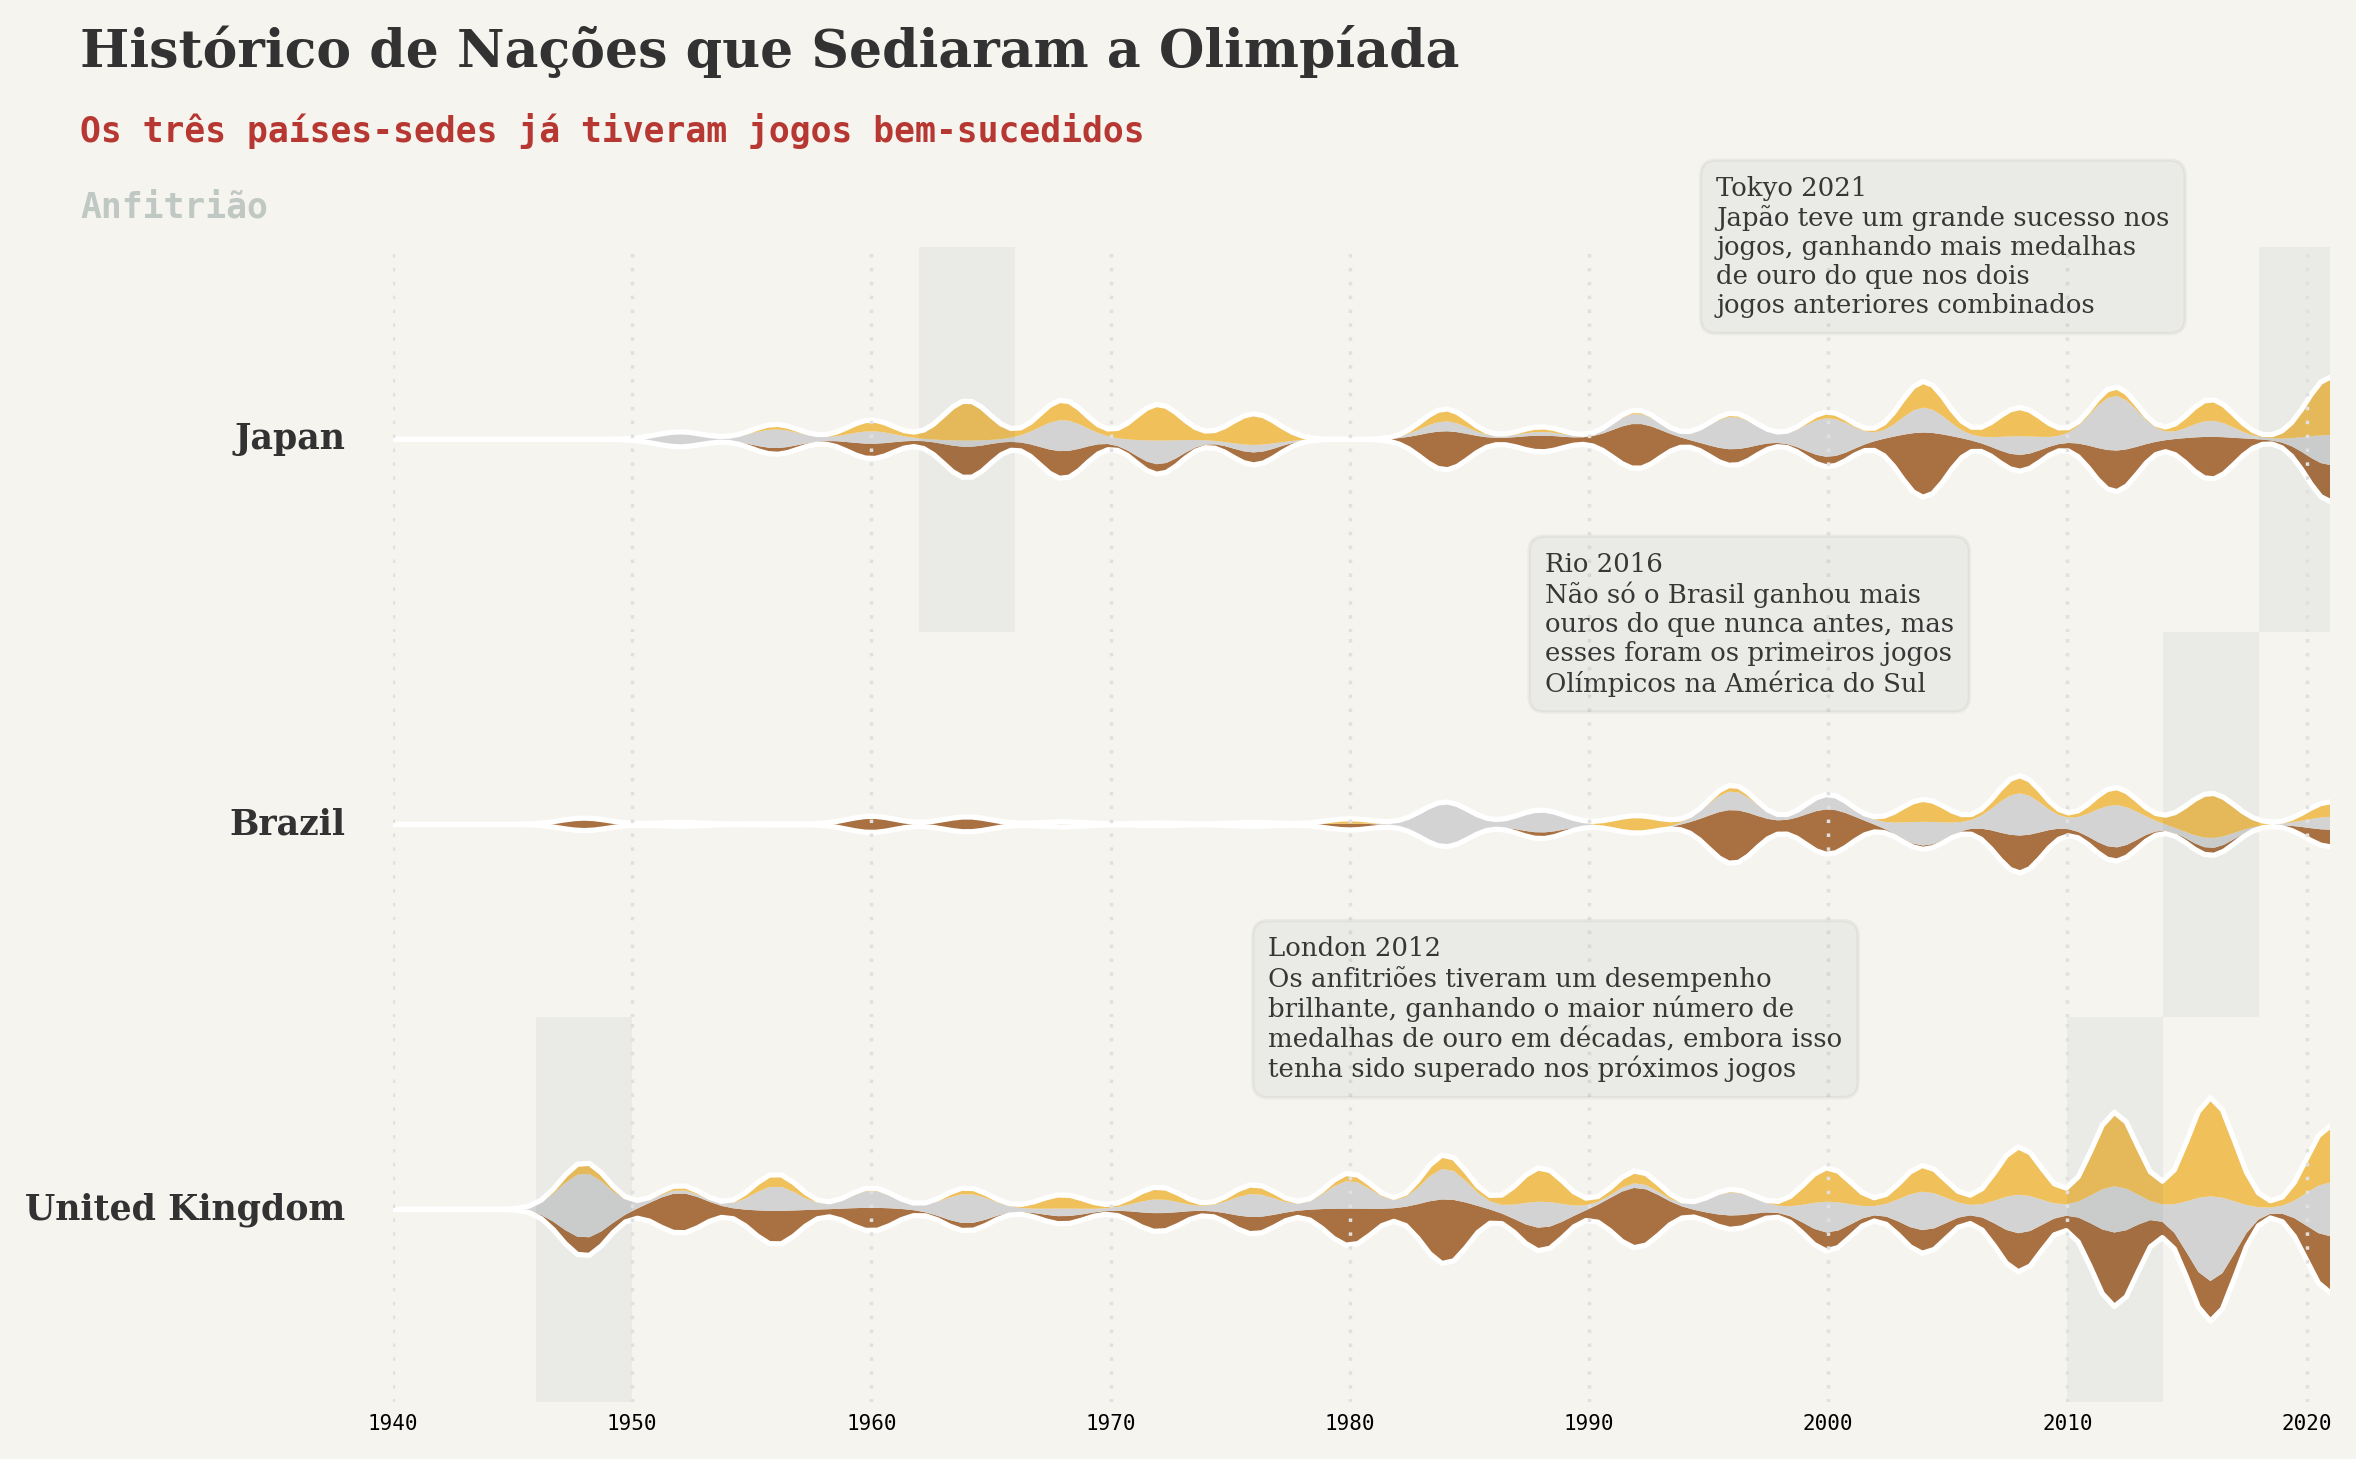

In [26]:
# Function for lightening colors
# https://www.python-graph-gallery.com/

# Função para ajustar brilho do mapa
def ajuste_brilho(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])


# Função para suavização
def suavizacao(x, y, grid, sd):
    larg = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    larg = larg / larg.sum(0)
    return (larg * y).sum(1)


# Plot
fig, ax = plt.subplots(3,1, figsize=(10, 6),dpi=250, facecolor=background_color)


cores = ['#a97142', 'lightgray', '#f0c05a']

x_ticks = [1940,1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

for axes, nacao in enumerate(['Japan', 'Brazil', 'United Kingdom']):
        # Definindo e transformando os dados
        stream = df_new.query(f"region = ='{nacao}'")[['Year','Gold', 'Silver','Bronze']]
        y = [stream['Bronze'].values, stream['Silver'].values, stream['Gold'].values]
        x = np.array(df_new.query(f"region == '{nacao}'")['Year'])

        grid = np.linspace(x.min(), x.max(), num=250)
        y_suavizado = [suavizacao(x, y_, grid, 1) for y_ in y]

        # Construindo plot
        ax[axes].stackplot(grid, y_suavizado, baseline="sym", colors=cores)

        line = np.array(y_suavizado).sum(0)
        ax[axes].plot(grid, line / 2, lw=1.5, color="white")
        ax[axes].plot(grid, -line / 2, lw=1.5, color="white")


        ax[axes].text(1938,0,f'{nacao}',ha='right',va='center',fontfamily='serif',fontweight='bold',color='#323232')

        # Ajustes nos eixos e mudanças visuais
        ax[axes].set_ylim(-25, 25)
        ax[axes].set_xlim(1940, 2021)
        ax[axes].set_facecolor(background_color)
        ax[axes].spines[:].set_visible(False)
        ax[axes].yaxis.set_visible(False)
        ax[axes].tick_params(axis=u'both', which=u'both',length=0)
        for x_tick in x_ticks:
                ax[axes].axvline(x_tick, color='#e0e0e0', ls=(0, (1, 3)),lw=1, zorder=10)

for axes in range(0,2):
    ax[axes].xaxis.set_visible(False)

# Sombreando área no periodo em que os paises sediaram os jogos

ax[2].tick_params(axis='x', labelsize=6, color='#4d4d4d')
ax[2].set_xticks(x_ticks)
#ax[0].xaxis.tick_top()

ax[0].axvspan(2018,2022, facecolor='#244747',alpha=0.05)
ax[0].axvspan(1962,1966, facecolor='#244747',alpha=0.05)

ax[1].axvspan(2014,2018, facecolor='#244747',alpha=0.05)

ax[2].axvspan(2010,2014, facecolor='#244747',alpha=0.05)
ax[2].axvspan(1946,1950, facecolor='#244747',alpha=0.05)


# Titulo e Subtitulo

fig.text(0,1,"Histórico de Nações que Sediaram a Olimpíada ", fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
fig.text(0,0.95, 'Os três países-sedes já tiveram jogos bem-sucedidos', fontsize=10,fontweight='bold',color='#B73832')
fig.text(0,0.9, 'Anfitrião', fontsize=10,fontweight='bold',color='#244747',alpha=0.25)

##

# Anotações textutais
TEXTS = [
    {
        "text": """Tokyo 2021
Japão teve um grande sucesso nos
jogos, ganhando mais medalhas
de ouro do que nos dois
jogos anteriores combinados""",
        "ax": 0,
        "x": 0.8,
        "y": 1,
        "color": ajuste_brilho("#323232", 1.1)
    },

    {
        "text": """Rio 2016
Não só o Brasil ganhou mais
ouros do que nunca antes, mas
esses foram os primeiros jogos
Olímpicos na América do Sul""",
        "ax": 1,
        "x": 0.7,
        "y": 1.02,
        "color": ajuste_brilho("#323232", 1.1)
    },

        {
        "text": """London 2012
Os anfitriões tiveram um desempenho
brilhante, ganhando o maior número de
medalhas de ouro em décadas, embora isso
tenha sido superado nos próximos jogos""",
        "ax": 2,
        "x": 0.6,
        "y": 1.02,
        "color": ajuste_brilho("#323232", 1.1)
    }
]

for text_box in TEXTS:
    ax[text_box["ax"]].text(
        x = text_box["x"],
        y = text_box["y"],
        s = text_box["text"],
        ha="center",
        va="center",
        ma="left",
        fontsize=7.5,fontfamily='serif',
        color=text_box["color"],
        bbox=dict(
            boxstyle="round",
            facecolor='#244747',alpha=0.05,
            edgecolor=text_box["color"],
            pad=0.6
        ),
        transform=ax[text_box["ax"]].transAxes,
        zorder=999
    )
##
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()


## Olimpiadas de Verão (Summer)

Agora vou ampliar minha visão.

Veja como a tabela de classificação se compara quando consideramos todos os Jogos Olímpicos de Verão.

In [27]:
medalhas = df.groupby(['region','Medal'])['Medal'].count().unstack().fillna(0).astype(int)

medalhas['Total'] = medalhas['Bronze'] + medalhas['Silver'] + medalhas['Gold']

medalhas = medalhas[['Bronze','Silver','Gold','Total']].sort_values(by='Total', ascending=False)

medalhas.iloc[:15].style.set_caption('Medalhas por Nações: Summer Olympic Games [Top 15]')\
.bar(subset=['Gold'], color='#f0c05a')\
.bar(subset=['Silver'], color='Lightgray')\
.bar(subset=['Bronze'], color='#a97142')\
.background_gradient(subset=['Total'], cmap='BuGn')

Medal,Bronze,Silver,Gold,Total
region,,,,
United States of America,1197,1333,2472,5002
Russia,994,974,1220,3188
Germany,1064,987,1075,3126
United Kingdom,620,729,636,1985
France,587,575,465,1627
Italy,454,474,518,1446
Australia,515,456,362,1333
Hungary,363,328,432,1123
Sweden,358,396,354,1108


In [28]:
sedes_lista = list(df_new.query("Is_Host == 1")['Host_Country'].value_counts().index)

medalhas_temp = medalhas.reset_index()
medalhas_map = pd.merge(global_polygons, medalhas_temp, left_on='name',right_on='region')
medalhas_map['Hosted'] = np.where(medalhas_map['name'].isin(sedes_lista),1,0)

Vejamos agora a distribuição das medalhas em um mapa.

Quanto mais escura a cor, mais medalhas um país ganhou

In [29]:
def rd2(x):
    return round(x, 2)

Temp = medalhas_map

minimum, maximum = Temp["Total"].quantile([0.05, 0.95]).apply(rd2)
mean = round(Temp["Total"].mean(), 2)


colormap = branca.colormap.LinearColormap(
    colors=["#f2f0f7", "#cbc9e2", "#9e9ac8", "#756bb1", "#54278f"],
    index=Temp["Total"].quantile([0.25, 0.5, 0.85, 0.95]),
    vmin=minimum,
    vmax=maximum,
)

colormap.caption = "Total medals"

from folium.plugins import Search
from folium.plugins import HeatMap


m = folium.Map(location=(50,0),zoom_start=3)


def style_function(x):
    return {
        "fillColor": colormap(x["properties"]["Total"]),
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.5,
    }


Map_Layer = folium.GeoJson(
    Temp,
    name="Medalhas",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["name","Total","Gold","Silver","Bronze"], aliases=["País","Medalhas","Ouro","Prata","Bronze"], localize=True
    ),
).add_to(m)


plugins.Search(Map_Layer,position='topleft',
                           search_zoom=5,placeholder="Procurar país",weight=3,
                           search_label='region',
                           geom_type='Polygon').add_to(m)


minimap = plugins.MiniMap()
m.add_child(minimap)

folium.LayerControl().add_to(m)
colormap.add_to(m)

m

A seguir, quero uma visão geral do desempenho de cada país; quando sediam as Olimpíadas, quando não o fazem e em média.

Primeiro, vamos olhar para todas as nações ao longo do tempo

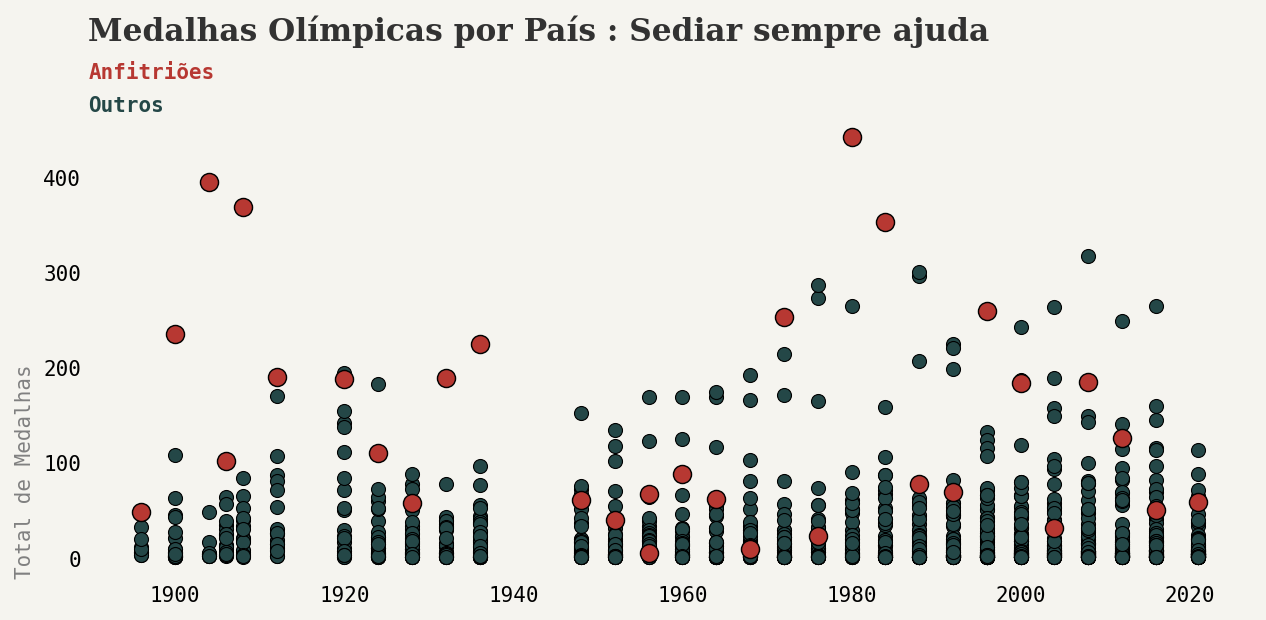

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,4), facecolor=background_color)

# Scatterplot
sns.scatterplot(data=df_new.query("Is_Host == 0"), x='Year', y='Total Medals', s=45, ec='black', color='#244747',ax=ax)
sns.scatterplot(data=df_new.query("Is_Host == 1"), x='Year', y='Total Medals', s=75, ec='black', color='#B73832',ax=ax)

x_inicio, x_final = ax.get_xlim()
y_inicio, y_final = ax.get_ylim()

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_ylabel("Total de Medalhas",fontfamily='monospace',loc='bottom',color='gray')
ax.set_xlabel("")

ax.set_facecolor(background_color)
ax.set_axisbelow(True)

# Retirando bordas
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)

# Titulo e subtítulo
ax.text(x_inicio,y_final+80, 'Medalhas Olímpicas por País : Sediar sempre ajuda', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicio,y_final+40, 'Anfitriões', fontsize=10,fontweight='bold',color='#B73832')
ax.text(x_inicio,y_final+5, 'Outros', fontsize=10,fontweight='bold',color='#244747')

plt.show()


Vemos que as nações anfitriãs parecem obter totais de medalhas mais elevados do que outras nações.

No entanto, devemos encarar isto com cautela, já que muitas vezes são as nações ricas que acolhem os jogos, pelo que se espera que tenham um desempenho melhor de qualquer maneira.

**Países sedes**

Portanto, sabemos que várias nações parecem ter um bom desempenho consistente nos Jogos Olímpicos. Mas não é isso que este projeto pretende confirmar.

Agora é hora de mudar o foco para aqueles que sediaram os jogos.

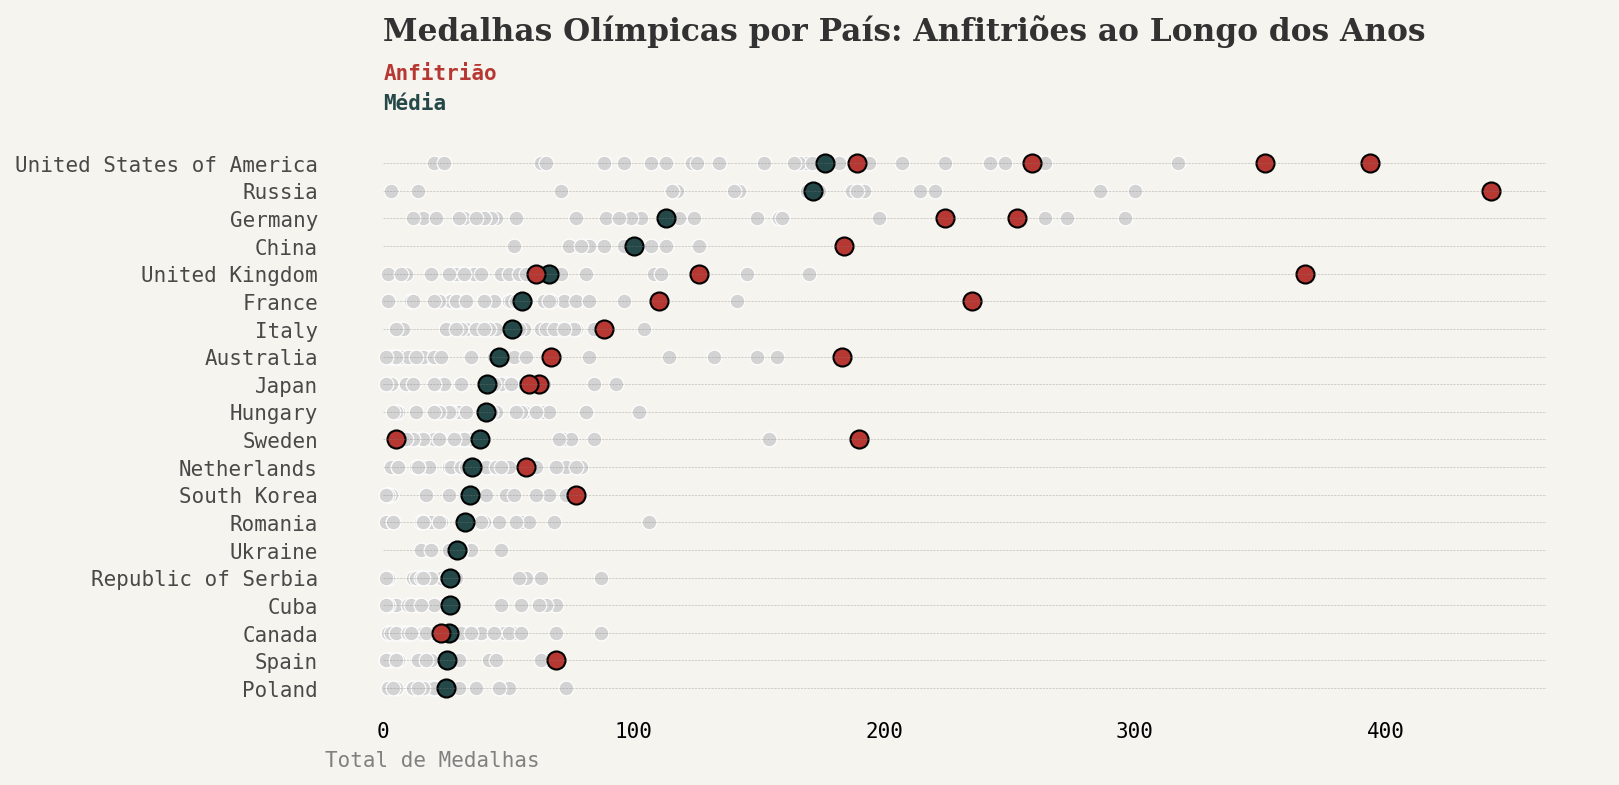

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11, 5), facecolor=background_color)

# top 20
top_list_ = df_new.groupby('region')['Total Medals'].mean().sort_values(ascending=False).reset_index()[:20].sort_values(by='Total Medals',ascending=True)

plot = 1
for pais in top_list_['region']:
    mean = df_new[df_new['region'] == pais].groupby('region')['Total Medals'].mean()
    # historicco de medalhas
    sns.scatterplot(data=df_new[df_new['region'] == pais], y=plot, x='Total Medals',color='lightgray',s=50,ax=ax)
    # média
    sns.scatterplot(data=df_new[df_new['region'] == pais], y=plot, x=mean,color='#244747',ec='black',linewidth=1,s=75,ax=ax)
    # quando sede
    sns.scatterplot(data=(df_new[(df_new['region'] == pais) & (df_new['Is_Host'] == 1)]), y=plot, x='Total Medals',color='#B73832',ec='black',linewidth=1,s=75,ax=ax)
    plot += 1

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['region'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Total de Medalhas",fontfamily='monospace',loc='left',color='gray')
ax.set_facecolor(background_color)
ax.hlines(y=top_list_.index+1, xmin=0, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)

# Retirando a borda
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)

# Titulo e Subtítulo
ax.text(0,Yend+3.5, 'Medalhas Olímpicas por País: Anfitriões ao Longo dos Anos', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(0,Yend+2.1, 'Anfitrião', fontsize=10,fontweight='bold',color='#B73832')
ax.text(0,Yend+1, 'Média', fontsize=10,fontweight='bold',color='#244747')


plt.show()

Concentrando-se apenas nas nações que sediaram alguma olimpiada ganhamos muitas informações com apenas um visual. Então, o que vemos:

* Desempenho histórico (pontos cinza)

* Desempenho médio (pontos azuis)

* Desempenho ao hospedar (pontos vermelhos)

Parece claro que quando uma nação sedia as Olimpíadas, seu desempenho é melhor!

In [32]:
Temp = medalhas_map

colormap = branca.colormap.LinearColormap(
    colors=["#f2f0f7",  "#B73832"],
    index=Temp["Hosted"].quantile([0.05, 0.5]),
    vmin=0,
    vmax=1,
)

colormap.caption = "Hosted"

from folium.plugins import Search
from folium.plugins import HeatMap


m = folium.Map(location=(50,0),zoom_start=3)


def style_function(x):
    return {
        "fillColor": colormap(x["properties"]["Hosted"]),
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.5,
    }


Map_Layer = folium.GeoJson(
    Temp,
    name="Hosted",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["name","Total","Gold","Silver","Bronze"], aliases=["País","Medalhas","Ouro","Prata","Bronze"], localize=True
    ),
).add_to(m)


plugins.Search(Map_Layer,position='topleft',
                           search_zoom=5,placeholder="Procurar país",weight=3,
                           search_label='region',
                           geom_type='Polygon').add_to(m)


minimap = plugins.MiniMap()
m.add_child(minimap)

folium.LayerControl().add_to(m)
colormap.add_to(m)

m

### O desempenho varia ao sediar e não sediar?

Vamos pegar uma amostra do novo dataframe e representar graficamente os totais médios de medalhas para cada nação, tanto quando não sediaram as Olimpíadas quanto quando o fizeram.

In [33]:
sample = df_new.groupby(['region','Is_Host'])['Gold'].mean().unstack().dropna()
sample = sample.rename(columns={0 : "Não Sediou", 1 : "Sediou"})
sample = sample.reset_index().query("region == 'Japan' | region == 'Brazil' | region == 'United Kingdom' | region == 'China' | region == 'Greece' ").set_index('region')

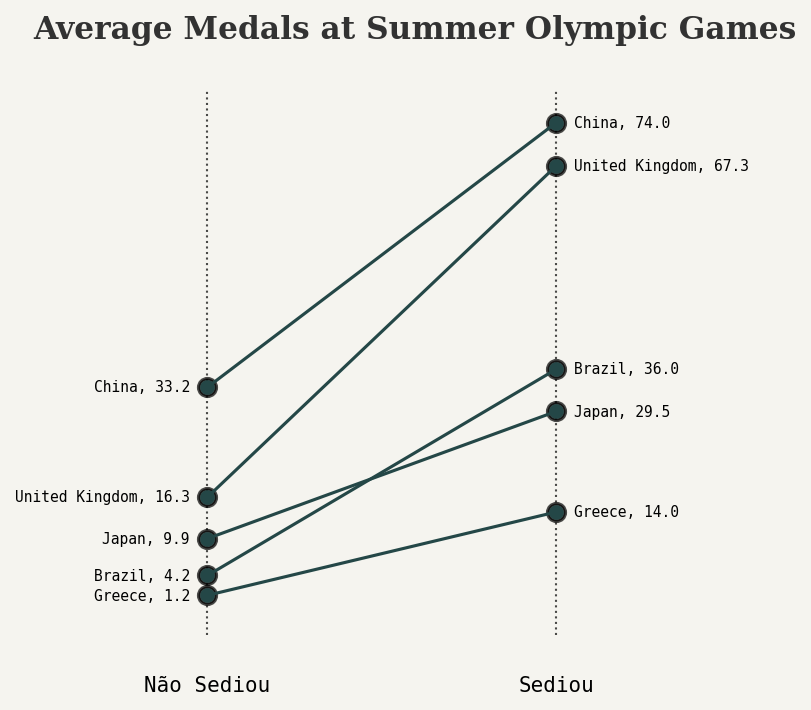

In [34]:
import matplotlib.lines as mlines

low_c = '#B73832'
high_c = '#244747'

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['Não Sediou'])]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['Sediou'])]
klass = [low_c if (y1-y2) < 0 else high_c for y1, y2 in zip(sample['Não Sediou'], sample['Sediou'])]

# desenhando linhas
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color=low_c if p1[1]-p2[1] > 0 else high_c, marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(6,5), dpi= 150, facecolor=background_color)

ax.set_facecolor(background_color)
ax.vlines(x=1, ymin=-5, ymax=100, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=-5, ymax=100, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# plots
ax.scatter(y=sample['Não Sediou'], x=np.repeat(1, sample.shape[0]), s=75,linewidth=1.5, color='black', alpha=0.7)
ax.scatter(y=sample['Sediou'], x=np.repeat(3, sample.shape[0]), s=75, linewidth=1.5,color='black', alpha=0.7)

# Linha de segmento e anotações
for p1, p2, c in zip(sample['Não Sediou'], sample['Sediou'], sample.index):
    newline([1,p1], [3,p2])
    ax.text(1-0.1, p1, c + ', ' + str(round(p1,1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':7})
    ax.text(3+0.1, p2, c + ', ' + str(round(p2,1)), horizontalalignment='left', verticalalignment='center', fontdict={'size':7})


ax.text(0,87,"Average Medals at Summer Olympic Games", fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')

ax.set(xlim=(0,4), ylim=(-10,sample.max().max()+5), ylabel='') #ylim=(),
ax.set_xticks([1,3])
ax.set_xticklabels(["Não Sediou", "Sediou"],fontsize=10)
#ax.xaxis.tick_top()

for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)

ax.tick_params(axis='both',which='both',length=0,labelleft=False)
plt.rcParams["font.family"] = "monospace"

plt.show()

Esse visual é muito interessante.

Vemos que todas as nações melhoraram drasticamente sua média total de medalhas quando sediaram jogos olímpicos.

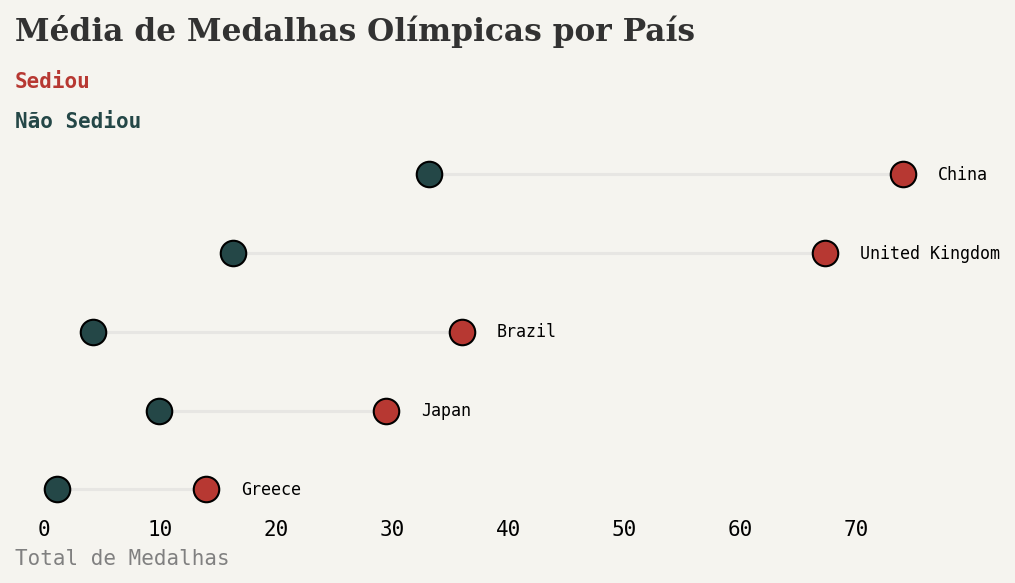

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8,3), facecolor=background_color)

valor1 = sample['Não Sediou']
valor2 = sample['Sediou']


df_ordenado = sample.sort_values(by='Sediou', ascending=True)
my_range=range(1,len(df_ordenado.index)+1)


plt.hlines(y=my_range, xmin=df_ordenado['Não Sediou'], xmax=df_ordenado['Sediou'], color='lightgray', alpha=0.4,zorder=1)
plt.scatter(df_ordenado['Não Sediou'], my_range, color='#244747', alpha=1, ec='black',label='Não Sediou',s=150)
plt.scatter(df_ordenado['Sediou'], my_range, color='#B73832', alpha=1 , ec='black', label='Sediou',s=150)


for i in range(0,5):
    ax.annotate(df_ordenado.index[i],
                   xy=((df_ordenado[["Não Sediou", "Sediou"]].max(axis=1)[i]+3),i+1),
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=8, color='black',rotation=0)


ax.axes.get_yaxis().set_ticks([])


for s in ['top','left', 'bottom', 'right']:
    ax.spines[s].set_visible(False)

ax.set_facecolor(background_color)
ax.set_xlabel("Total de Medalhas",fontfamily='monospace',loc='left',color='gray')
ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True)
ax.set_yticklabels([])

x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()


ax.text(x_inicial,y_final+1.5, 'Média de Medalhas Olímpicas por País', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial,y_final+0.9, 'Sediou', fontsize=10,fontweight='bold',color='#B73832')
ax.text(x_inicial,y_final+0.4, 'Não Sediou', fontsize=10,fontweight='bold',color='#244747')


plt.show()

### Desempenho de medalhas ao longo do tempo para países sede

Vimos as médias estáticas, mas agora vamos ver os jogos tal como aconteceram.

Primeiro, podemos ver a contagem de medalhas dos EUA ao longo do tempo. Vou destacar os jogos que eles sediaram.

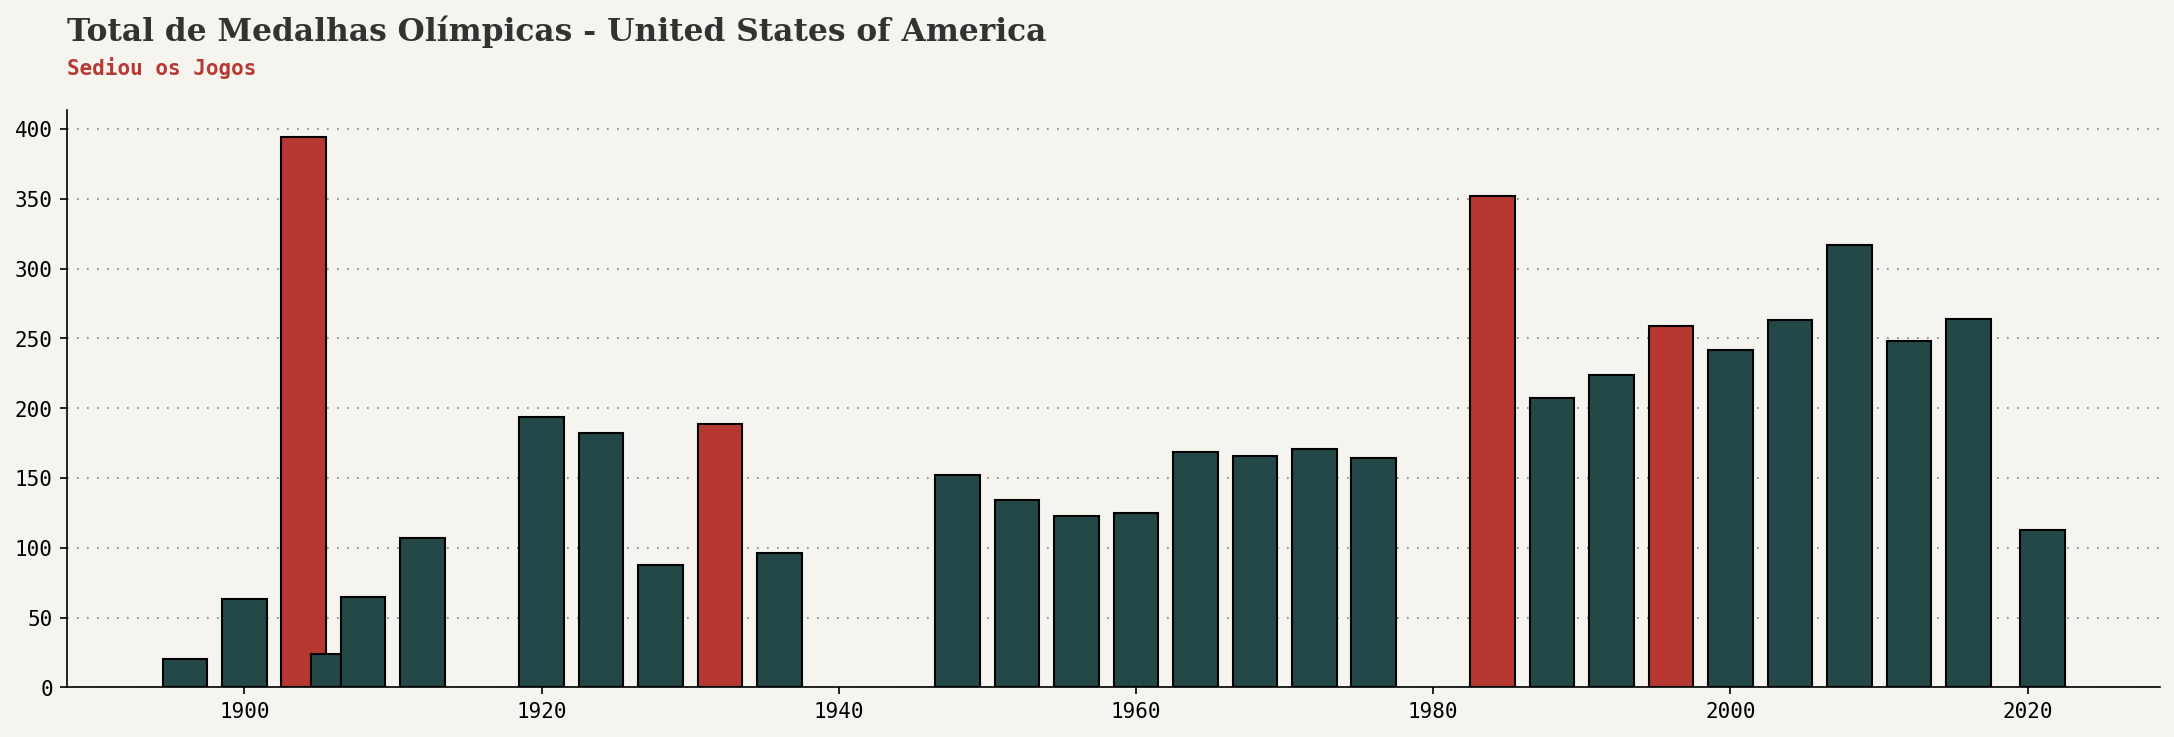

In [39]:
temp = df_new.query("region == 'United States of America'")


fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

color = ['#B73832' if i == 1 else '#244747' for i in temp['Is_Host']]

ax.bar(temp['Year'], temp['Total Medals'],width=3, color=color, ec='black')
ax.set_facecolor(background_color)
ax.grid(which='both', axis='y', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial,y_final+50, 'Total de Medalhas Olímpicas - United States of America', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial,y_final+25, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='#B73832')

plt.show()

Apesar de ter um bom desempenho consistente, parece que os EUA têm um desempenho ainda melhor quando são sede do torneio.

E quanto a outras nações. Vamos tentar o Reino Unido

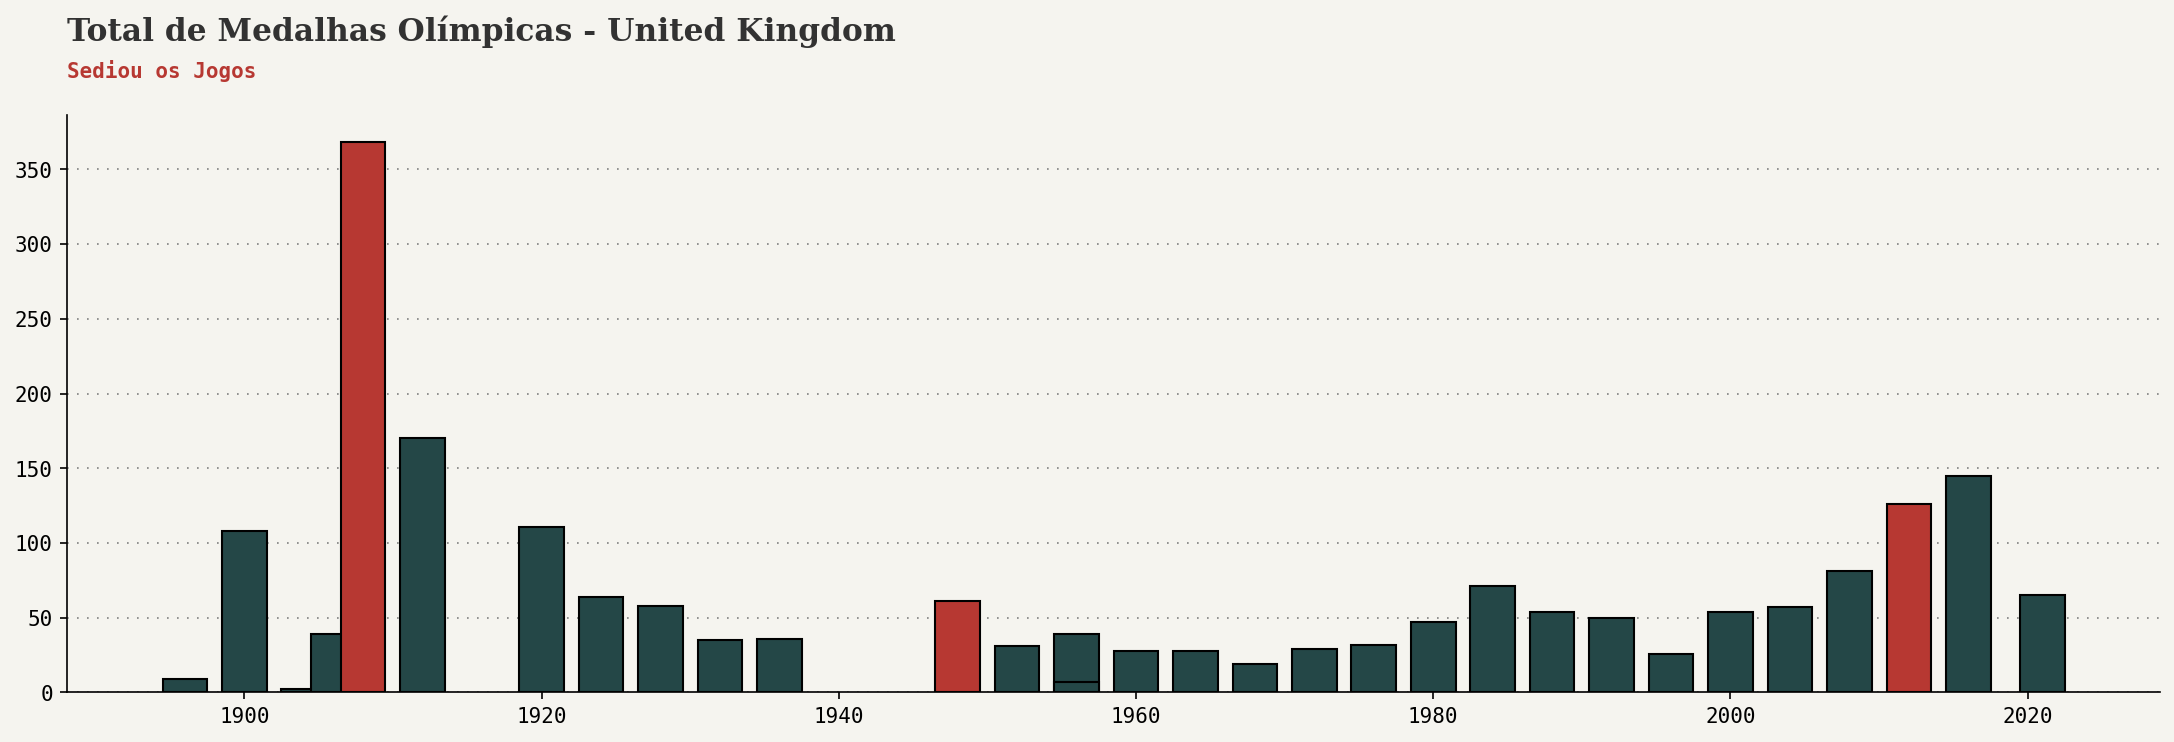

In [40]:
temp = df_new.query("region == 'United Kingdom'")


fig, ax = plt.subplots(1, 1, figsize=(18, 5), dpi=150, facecolor=background_color)

color = ['#B73832' if i == 1 else '#244747' for i in temp['Is_Host']]

ax.bar(temp['Year'], temp['Total Medals'],width=3, color=color, ec='black')
ax.set_facecolor(background_color)
ax.grid(which='both', axis='y', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial,y_final+50, 'Total de Medalhas Olímpicas - United Kingdom', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial,y_final+25, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='#B73832')

plt.show()

Novamente, parece que ser sede do torneio ajuda no desempenho.

No entanto, o Reino Unido estava numa tendência ascendente durante a década de 2000, por isso talvez isto tivesse continuado de qualquer maneira.

E as medalhas de ouro?

Até agora me concentrei no total de medalhas, pois acredito que todas as medalhas são impressionantes.

No entanto, podemos ver cada um separadamente...

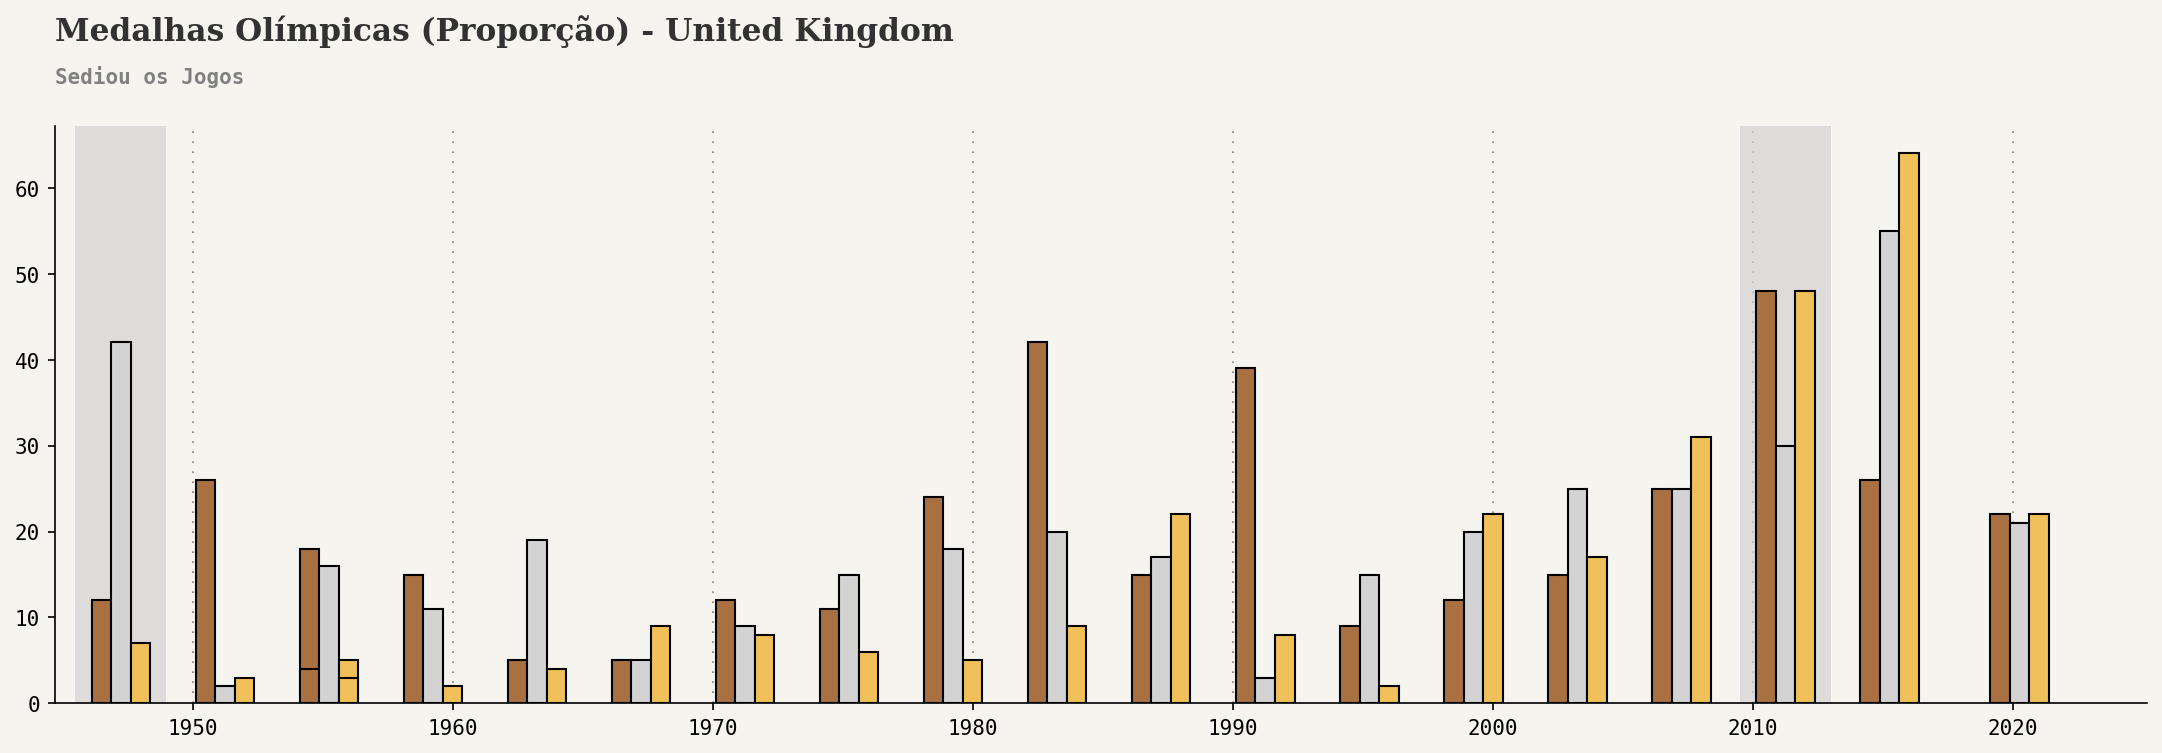

In [53]:
temp = df_new.query("region == 'United Kingdom' & Year > 1945")

fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

ax.set_facecolor(background_color)

color = ["#a97142", "lightgray", '#f0c05a']


# Anos em que foi sede dos jogos (destacando)
ax.axvspan(1949,1945.5, facecolor='lightgray',alpha=0.7)
ax.axvspan(2013,2009.5, facecolor='lightgray',alpha=0.7)

medals_list = ['Bronze', 'Silver', 'Gold']
width = 0.75
for i, medal in enumerate(np.array(medals_list)):
    ax.bar(temp['Year']+(width*(i-2)), temp[medal], width, color=color[i], label=medal, ec='black')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial+3,y_final+10, 'Medalhas Olímpicas (Proporção) - United Kingdom', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial+3,y_final+5, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='gray')

ax.set_xlim(x_inicial+3, x_final)

ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))

ax.set_axisbelow(True)

plt.show()

O Reino Unido, ao sediar em 2012, teve um ótimo desempenho, com o maior número de medalhas de ouro de todos os tempos. No entanto, isso foi superado no Rio 2016.

Proporções

Vamos nos afastar dos totais e nos aproximar das proporções

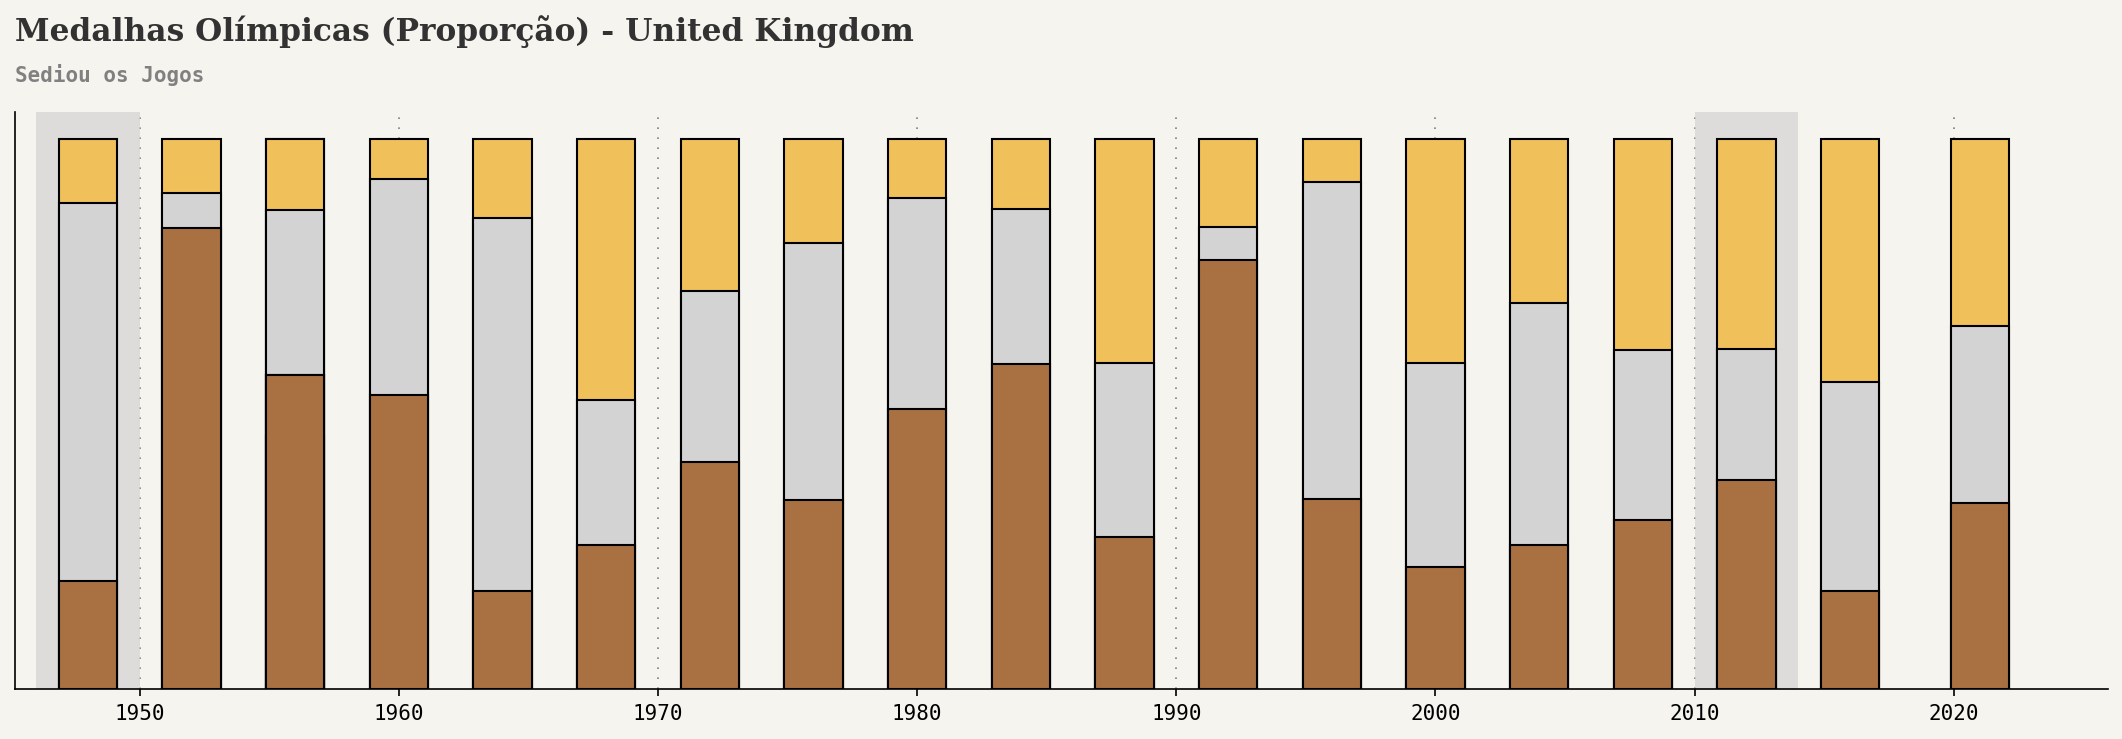

In [52]:
stack_temp = df_new.query("region == 'United Kingdom' & Year > 1945")[['Year','Bronze','Silver','Gold']].set_index('Year')
stack_temp = (stack_temp.T/stack_temp.sum(axis=1)).cumsum().T

fig, ax = plt.subplots(1,1, figsize=(18,5), facecolor=background_color)

# Host years
ax.axvspan(1950,1946, facecolor='lightgray',alpha=0.7)
ax.axvspan(2014,2010, facecolor='lightgray',alpha=0.7)


color = ["#a97142", "lightgray", '#f0c05a']
medals_list = ['Bronze', 'Silver', 'Gold']

for i, medal in enumerate(medals_list[::-1]):
    sentims = stack_temp[medal]
    ax.bar(sentims.index, sentims, color=color[::-1][i], label=medal, width=2.25, ec='black')

ax.set_facecolor(background_color)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)


x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.set_xlim(x_inicial+3, x_final)
ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)
ax.get_yaxis().set_visible(False)

ax.text(x_inicial+3,y_final+0.13, 'Medalhas Olímpicas (Proporção) - United Kingdom', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial+3,y_final+0.055, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='gray')


plt.show()

Conforme mencionado anteriormente, a hospedagem parece ter um efeito positivo no total de medalhas, mas isso também parece valer para as medalhas de ouro.

E o Japão?

Como mencionei no início, fiquei impressionado com o Japão nesta olimpíada. Eles tiveram um desempenho melhor que o normal?

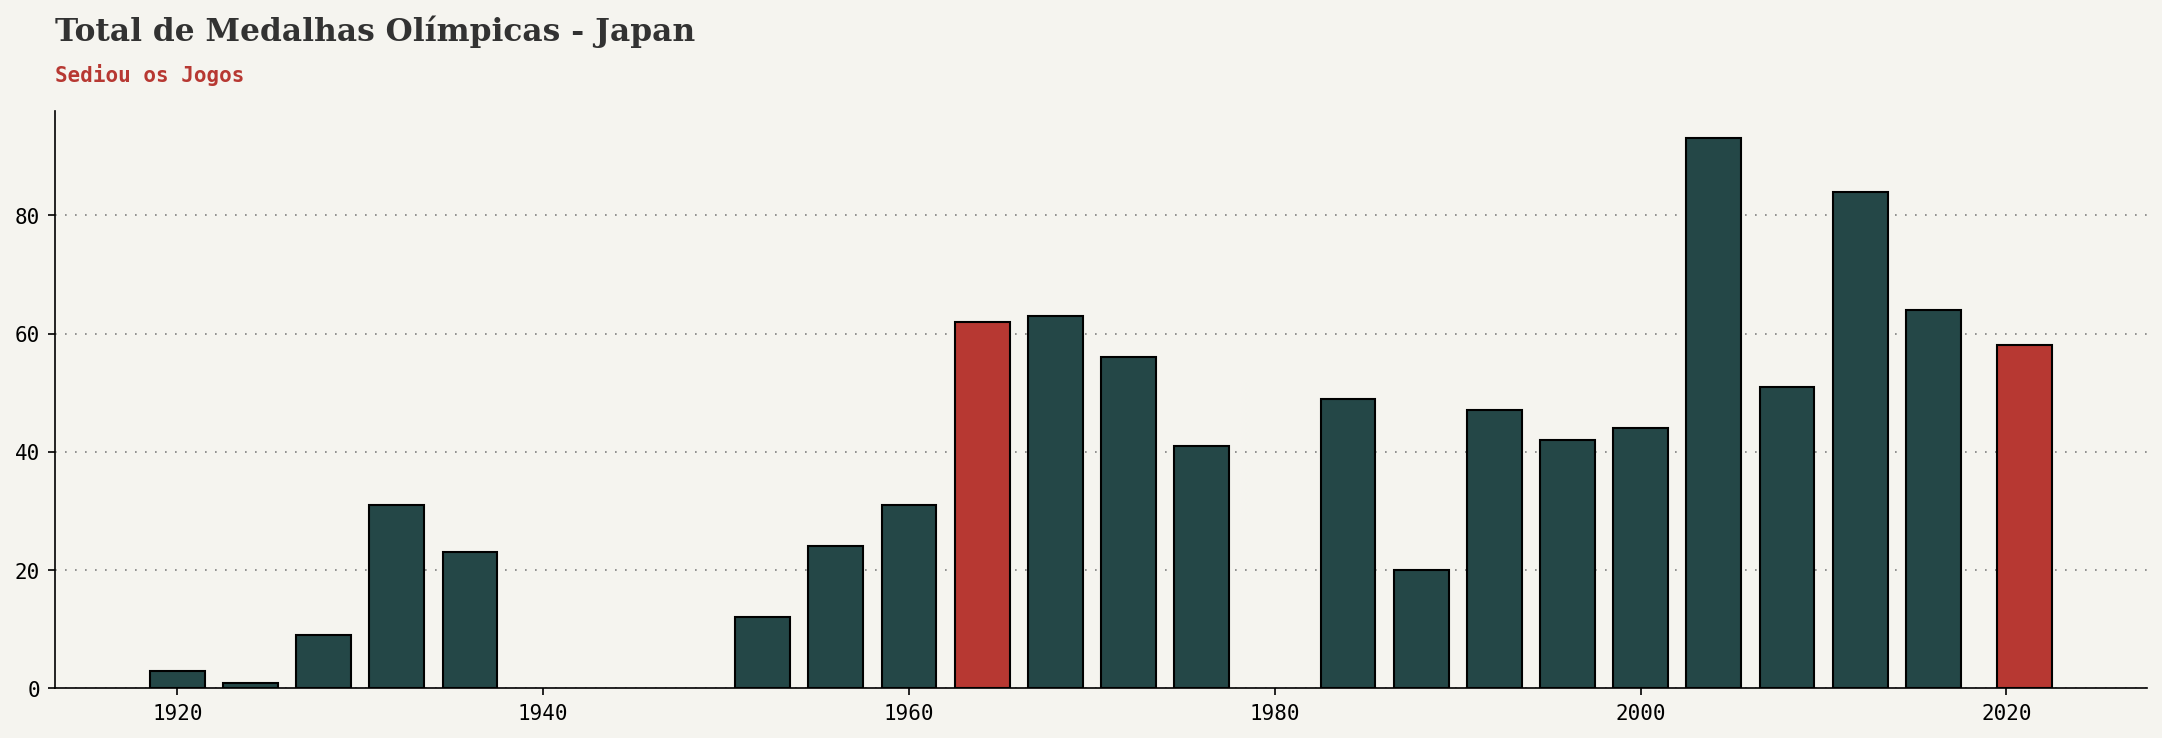

In [54]:
temp = df_new.query("region == 'Japan'")


fig, ax = plt.subplots(1, 1, figsize=(18, 5), dpi=150, facecolor=background_color)

color = ['#B73832' if i == 1 else '#244747' for i in temp['Is_Host']]

ax.bar(temp['Year'], temp['Total Medals'],width=3, color=color, ec='black')
ax.set_facecolor(background_color)
ax.grid(which='both', axis='y', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial,y_final+12, 'Total de Medalhas Olímpicas - Japan', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial,y_final+5, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='#B73832')

plt.show()

Curiosamente, a contagem total de medalhas do Japão não é muito extraordinária em comparação com as Olimpíadas anteriores. Embora ainda seja impressionante, nas últimas 5 participações olímpicas do Japão ele ocuparia o 4º lugar.

E as medalhas de ouro? Afinal, é assim que o quadro de medalhas costuma ser calculado

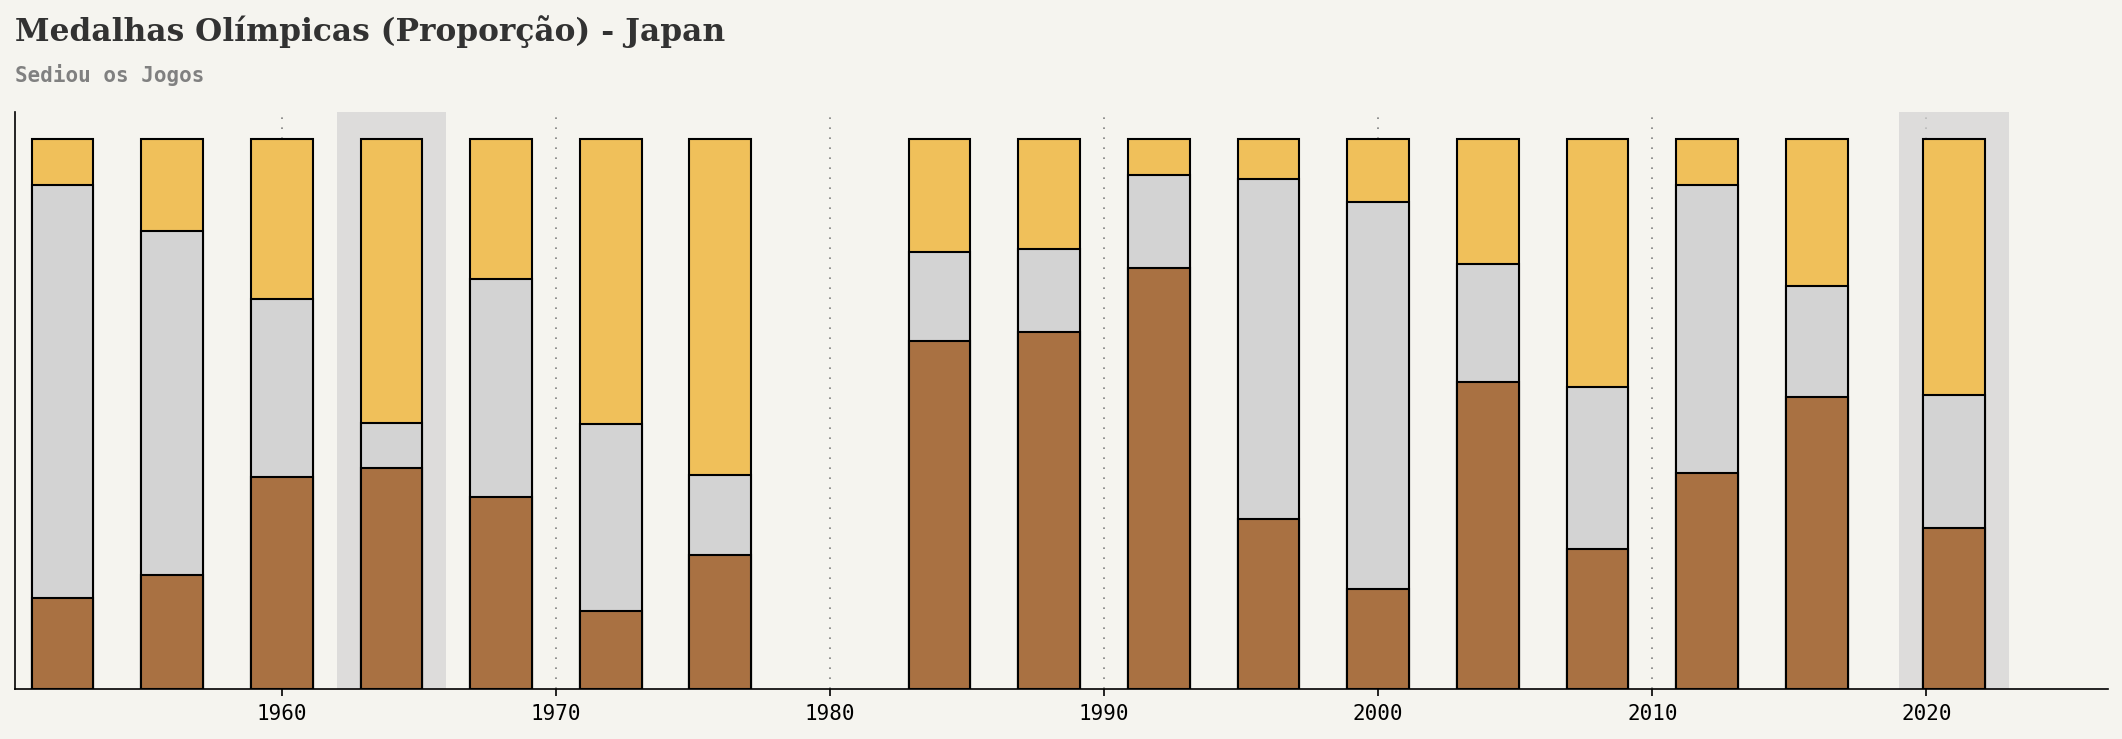

In [55]:
stack_temp = df_new.query("region == 'Japan' & Year > 1945")[['Year','Bronze','Silver','Gold']].set_index('Year')
stack_temp = (stack_temp.T/stack_temp.sum(axis=1)).cumsum().T

fig, ax = plt.subplots(1,1, figsize=(18,5), facecolor=background_color)

# Host years
ax.axvspan(2023,2019, facecolor='lightgray',alpha=0.7)
ax.axvspan(1966,1962, facecolor='lightgray',alpha=0.7)


color = ["#a97142", "lightgray", '#f0c05a']
medals_list = ['Bronze', 'Silver', 'Gold']

for i, medal in enumerate(medals_list[::-1]):
    sentims = stack_temp[medal]
    ax.bar(sentims.index, sentims, color=color[::-1][i], label=medal, width=2.25, ec='black')

ax.set_facecolor(background_color)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)


x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.set_xlim(x_inicial+3, x_final)

ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))

ax.set_axisbelow(True)
ax.get_yaxis().set_visible(False)

ax.text(x_inicial+3,y_final+0.13, 'Medalhas Olímpicas (Proporção) - Japan', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial+3,y_final+0.055, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='gray')

plt.show()

O Japão, sede de 2020 (2021), fez jogos fantásticos em termos de medalhas de ouro; ganhando a maior proporção de medalhas de ouro em mais de 40 anos.

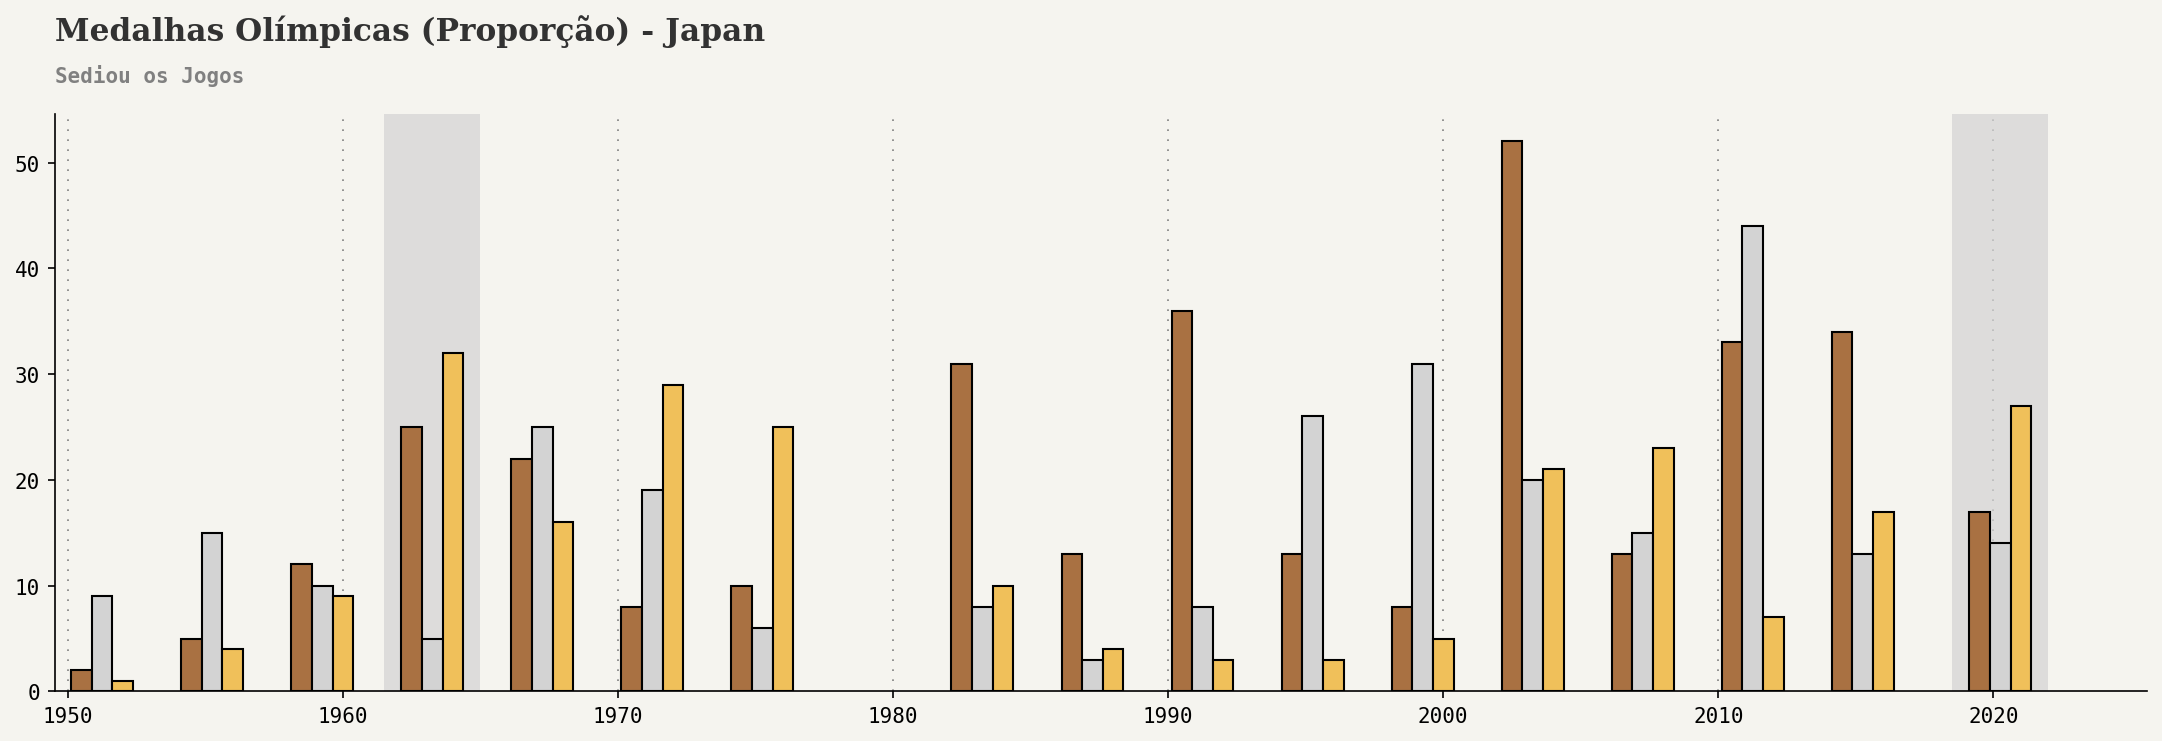

In [56]:
temp = df_new.query("region == 'Japan' & Year > 1945")

fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

ax.set_facecolor(background_color)

color = ["#a97142", "lightgray", '#f0c05a']


# Host years
ax.axvspan(2022,2018.5, facecolor='lightgray',alpha=0.7)
ax.axvspan(1965,1961.5, facecolor='lightgray',alpha=0.7)

medals_list = ['Bronze', 'Silver', 'Gold']
width = 0.75
for i, medal in enumerate(np.array(medals_list)):
    ax.bar(temp['Year']+(width*(i-2)), temp[medal], width, color=color[i], ec='black')


x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial+3,y_final+7, 'Medalhas Olímpicas (Proporção) - Japan', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial+3,y_final+3, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='gray')

ax.set_xlim(x_inicial+3, x_final)
ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

plt.show()

Não só a proporção de medalhas de ouro é maior do que o normal, como também o número absoluto. Este também foi o caso quando o Japão sediou os jogos na década de 60. Podemos ver isso mais claramente abaixo

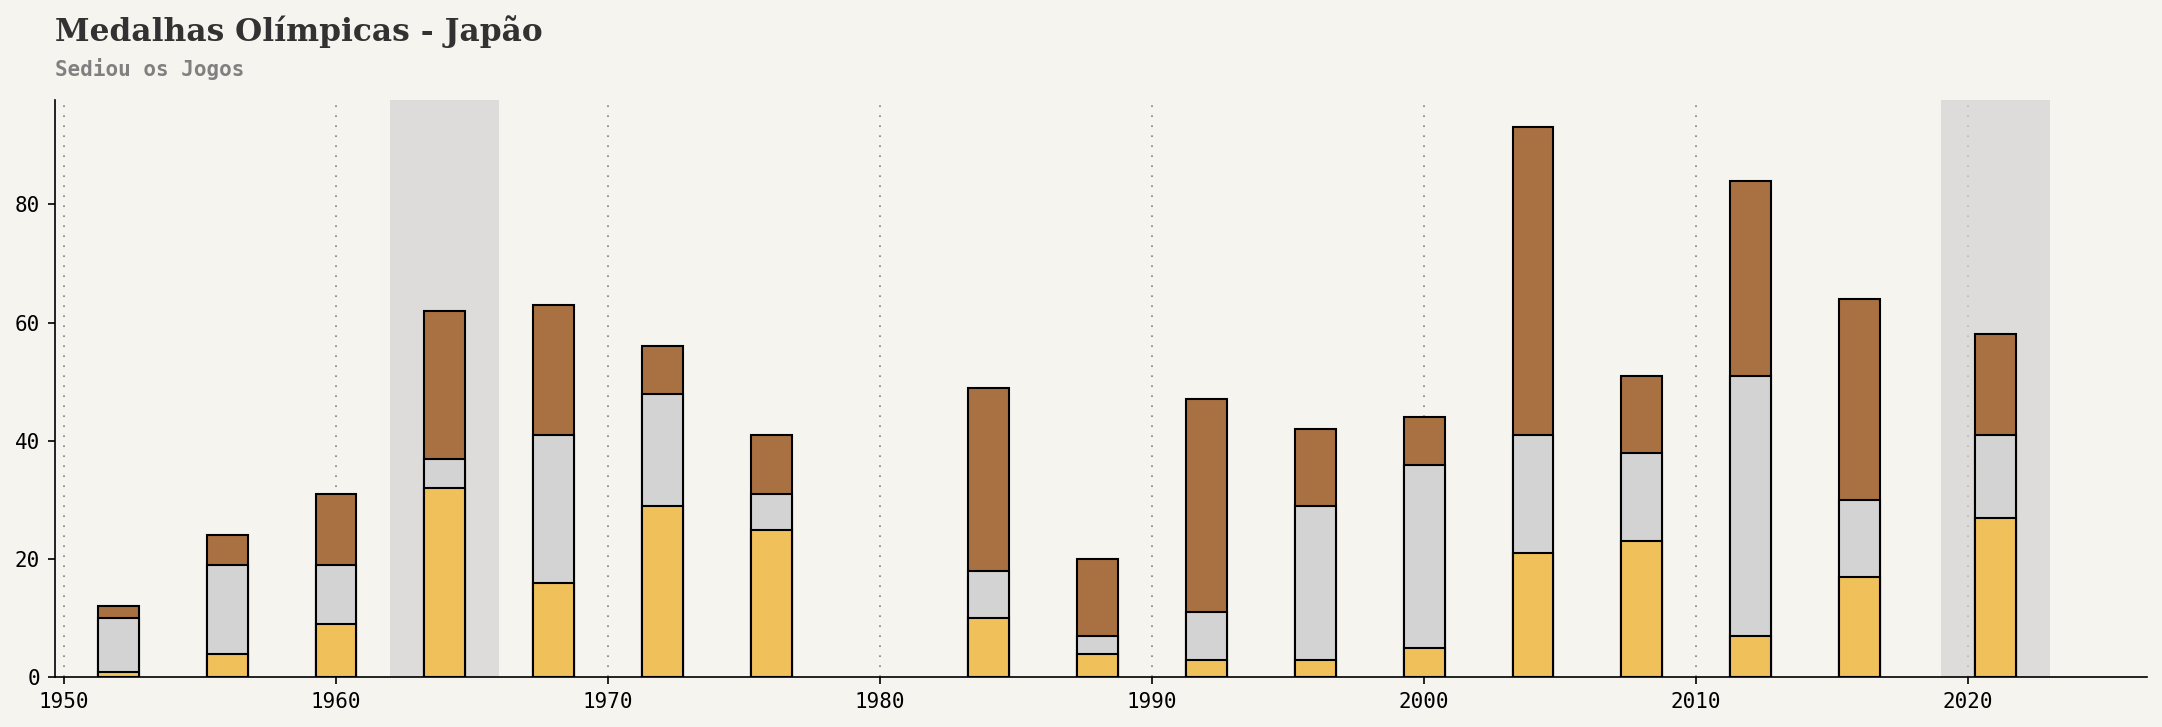

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

ax.set_facecolor(background_color)

color = ["#a97142", "lightgray", '#f0c05a']

# Host years
ax.axvspan(2023,2019, facecolor='lightgray',alpha=0.7)
ax.axvspan(1966,1962, facecolor='lightgray',alpha=0.7)


for i, medal in enumerate(medals_list):
    temp = df_new.query("region == 'Japan' & Year > 1945").groupby(['Year'])['Gold','Silver','Bronze'].sum().cumsum(axis=1)[medal]
    ax.bar(temp.index, temp, color=color[i],width=1.5,ec='black')


x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial+2,y_final+10, 'Medalhas Olímpicas - Japão', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial+2,y_final+4, 'Sediou os Jogos', fontsize=10,fontweight='bold',color='gray')

ax.set_xlim(x_inicial+2, x_final)
ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

plt.show()

## **Testes estatísticos**

Vimos através de nossa jornada visual que sediar as Olimpíadas parece levar a um melhor desempenho, mas agora faremos alguns testes estatísticos para descobrir se essas diferenças podem ou não ser consideradas significativas ou não

In [58]:
df_new

,Year,Host_Country,region,Bronze,Gold,Silver,Is_Host,Total Medals
0,1896,Greece,Australia,1,2,0,0,3
1,1896,Greece,Austria,2,2,1,0,5
2,1896,Greece,Denmark,3,1,2,0,6
3,1896,Greece,France,2,5,4,0,11
4,1896,Greece,Germany,2,25,5,0,32
...,...,...,...,...,...,...,...,...
88,2021,Japan,Ghana,1,0,0,0,1
89,2021,Japan,Grenada,1,0,0,0,1
90,2021,Japan,Kuwait,1,0,0,0,1
91,2021,Japan,Republic of Moldova,1,0,0,0,1


In [65]:
pais_sede = list(df_new.query("Is_Host == 1")['Host_Country'].value_counts().index)

nao_sediou = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 0")[['Bronze','Silver','Gold']].mean().reset_index()
sediou = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 1")[['Bronze','Silver','Gold']].mean().reset_index()

radar = pd.merge(sediou, nao_sediou, on='index')
radar.columns = ['Medalhas','Sediou', 'Não Sediou']
radar = radar.set_index('Medalhas').T.reset_index()
radar = radar[['index','Gold','Silver','Bronze']]

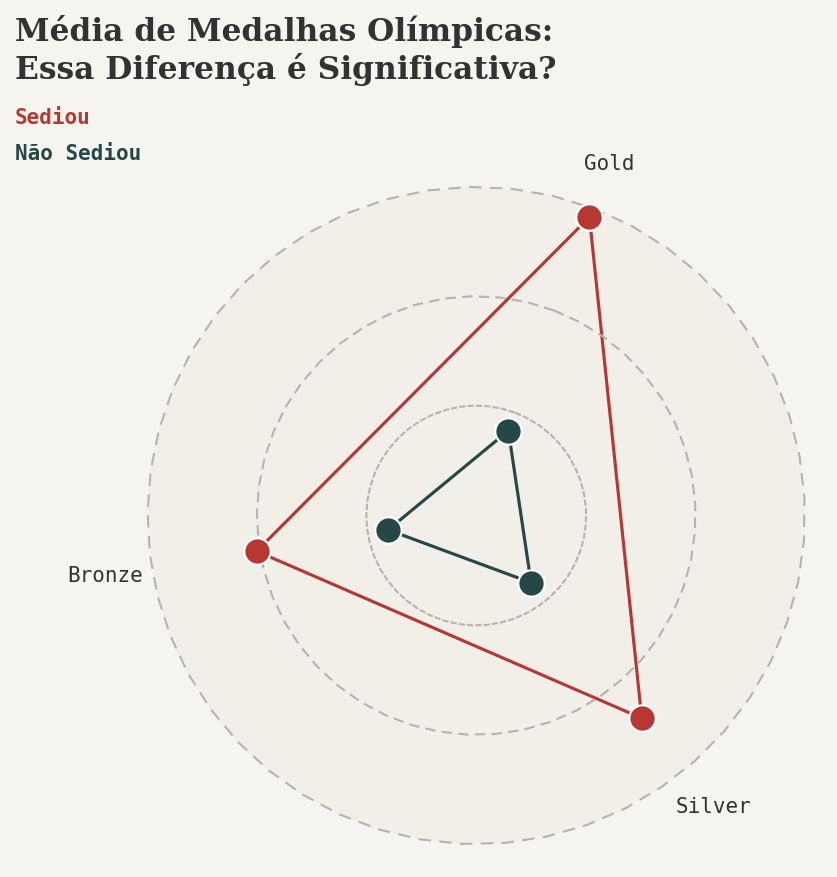

In [66]:
# Inpsired by Tuo Wang, https://tuowang.rbind.io/
# https://www.python-graph-gallery.com/
# Host or Not Host
comparacao = radar["index"].values.tolist()

medalhas = ['Gold', 'Silver','Bronze']
tam = len(medalhas)

colors = ["#B73832", "#244747"]

# Gerando ângulos nos quais os valores das variáveis numéricas são colocados
ANGULOS = [n / tam * 2 * np.pi for n in range(tam)]
ANGULOS += ANGULOS[:1]

# Gerando valores de ângulo de 0 a 2*pi
ANGULOS_P = np.linspace(0, 2 * np.pi)

# Círculos
H0 = np.ones(len(ANGULOS_P)) * 20
H1 = np.ones(len(ANGULOS_P)) * 40
H2 = np.ones(len(ANGULOS_P)) * 60

# Plot
fig = plt.figure(figsize=(6, 6), facecolor=background_color)
ax = fig.add_subplot(1,1,1, polar=True)
ax.set_facecolor(background_color)

# Girando o gráfico
ax.set_theta_offset(np.pi / 2.6)
ax.set_theta_direction(-1)

# Raio do gráfico
ax.set_ylim(-0.1, radar[['Gold','Silver','Bronze']].max().max()+5)

# Radar
for idx, sede in enumerate(comparacao):
    values = radar.iloc[idx].drop("index").values.tolist()
    values += values[:1]
    ax.plot(ANGULOS, values, c=colors[idx], linewidth=1.5, label=sede)
    ax.scatter(ANGULOS, values, s=160, c=colors[idx],ec='white',zorder=10)

ax.plot(ANGULOS_P, H0, ls=(0, (3, 1)),lw=1, c='#b3b3b3')
ax.plot(ANGULOS_P, H1, ls=(0, (5, 3)),lw=1, c='#b3b3b3')
ax.plot(ANGULOS_P, H2, ls=(0, (6, 4)),lw=1, c='#b3b3b3')
ax.fill(ANGULOS_P, H2, '#f2efe8')

# Limpeza e rótulos
ax.set_xticks(ANGULOS[:-1])
ax.set_xticklabels(medalhas, size=10, color='#323232')
ax.set_yticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

fig.text(0,0.98, 'Média de Medalhas Olímpicas:\nEssa Diferença é Significativa?', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
fig.text(0,0.93, 'Sediou', fontsize=10,fontweight='bold',color='#B73832')
fig.text(0,0.89, 'Não Sediou', fontsize=10,fontweight='bold',color='#244747')

plt.show()

Isso mostra o que vimos ao longo desta análise.

Usando apenas países que sediaram jogos olímpicos, qual é a média de medalhas quando hospedam e não hospedam. É claro que a hospedagem fornece a contagem mais alta, mas os países hospedam com pouca frequência, portanto, devemos realizar testes estatísticos para ter certeza dessa intuição

Porém mais uma vez faço a resalva, devemos encarar isto com cautela, já que muitas vezes são as nações ricas que acolhem os jogos, pelo que se espera que tenham um desempenho melhor de qualquer maneira.

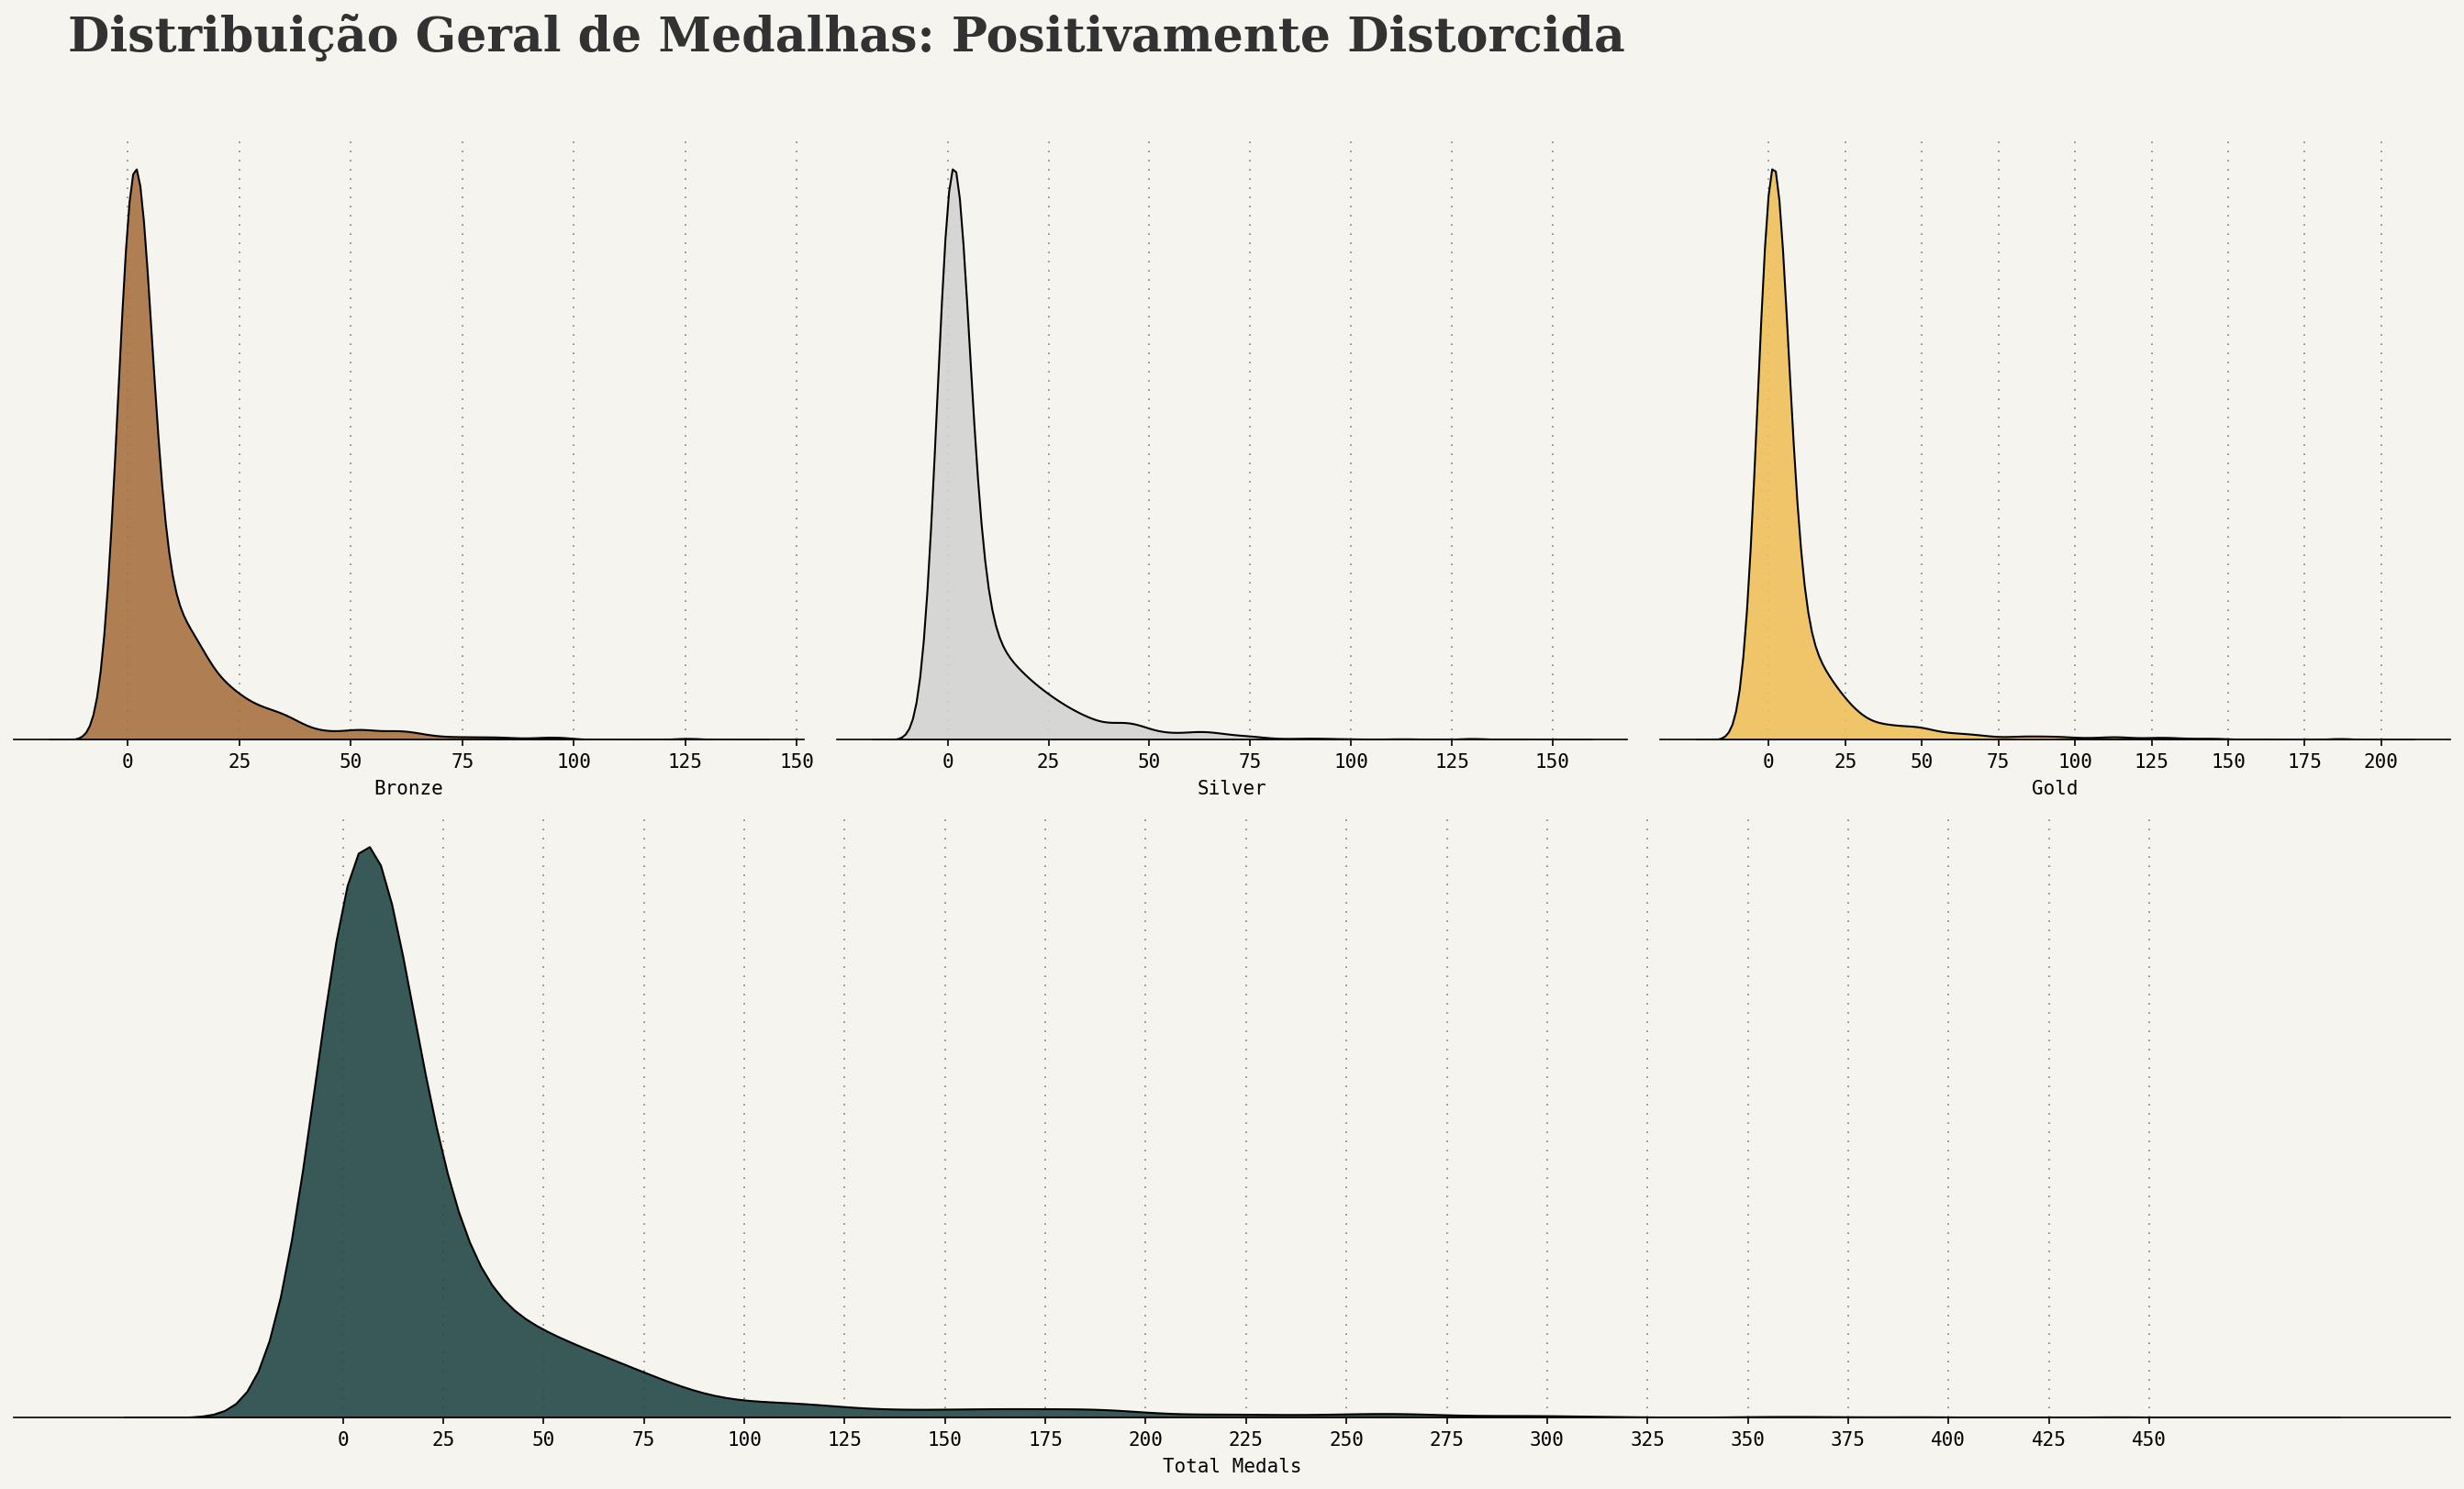

In [69]:
# Wrote this for 4 variables

fig = plt.figure(figsize=(18,10), facecolor=background_color)

colors = ['#a97142', 'lightgray', '#f0c05a', '#244747']

num = 0
var = ['Bronze', 'Silver', 'Gold', 'Total Medals']

plots = [(0,0), (0,1), (0,2), (1,0)]

data = df_new

for item in var:

    if plots[num] == plots[-1]:
        colspan=3
    else:
        colspan=1

    plt.subplot2grid((2,3), (plots[num]), colspan=colspan)

    ax = sns.kdeplot(data=data, x=item,color=colors[num],shade=True,  alpha=0.9, ec='black', cut=5)
    ax.set_facecolor(background_color)
    ax.tick_params(axis='y', left=False)
    ax.get_yaxis().set_visible(False)
    ax.set_axisbelow(True)
    ax.set_xlabel(item)
    ax.grid(which='major', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
    for s in ["top","right","left"]:
        ax.spines[s].set_visible(False)

    plt.xticks(list(np.arange(0,data[item].max()+25,25)))

    num +=1

x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

fig.text(0.03,1.05, 'Distribuição Geral de Medalhas: Positivamente Distorcida', fontsize=25,fontweight='bold',fontfamily='serif',color='#323232')


plt.tight_layout()
plt.show()

Ressaltamos que as medalhas não são distribuídas normalmente. Eles são positivamente distorcidos. Para mitigar isso, tomarei o logaritmo natural do total de medalhas.

Será esta diferença suficiente para declarar que as duas médias são de distribuições diferentes?

In [86]:
pais_sede = list(df_new.query("Is_Host == 1")['Host_Country'].value_counts().index)

# Calculando o log natural do total de medalhas
df_new['Total_Medals_NaturalLog'] = np.log(df_new['Total Medals'])

# Calculando estatísticas para países que não sediaram e sediaram
nao_sediou_amostra = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 0")['Total_Medals_NaturalLog'].count()
sediou_amostra = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 1")['Total_Medals_NaturalLog'].count()

nao_sediou_media = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 0")['Total_Medals_NaturalLog'].mean()
sediou_media = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 1")['Total_Medals_NaturalLog'].mean()

nao_sediou_std = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 0")['Total_Medals_NaturalLog'].std()
sediou_std = df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 1")['Total_Medals_NaturalLog'].std()

print("Média do Log Natural do Total de Medalhas quando Não Sedia:\n", nao_sediou_media)
print("Média do Log Natural do Total de Medalhas quando Sedia:\n", sediou_media, "\n")

nao_sediou_std_erro = nao_sediou_std/np.sqrt(nao_sediou_amostra)
print("Erro Padrão do Log Natural do Total de Medalhas quando Não Sedia:\n",nao_sediou_std_erro)

sediou_std_erro = sediou_std/np.sqrt(sediou_amostra)
print("Erro Padrão do Log Natural do Total de Medalhas quando Sedia:\n",sediou_std_erro)

Média do Log Natural do Total de Medalhas quando Não Sedia:
 3.086281690114543
Média do Log Natural do Total de Medalhas quando Sedia:
 4.566512430214569 

Erro Padrão do Log Natural do Total de Medalhas quando Não Sedia:
 0.06927049040753175
Erro Padrão do Log Natural do Total de Medalhas quando Sedia:
 0.19153671012884035


In [88]:
# Calcular o numerador e os denominadores das partes inferiores das fórmulas para os erros padrão
top = (sediou_media - nao_sediou_media)
d1 = nao_sediou_std**2 / nao_sediou_amostra
d2 = sediou_std**2 / sediou_amostra

# Calcular o erro padrão entre as médias
erros_padrao_entre_medias = top / np.sqrt(d1 + d2)

# Imprimir o resultado
print('Erros padrão entre médias:', erros_padrao_entre_medias)

Erros padrão entre médias: 7.26750565554929


Isto significa que é incrivelmente improvável que as duas médias sejam provenientes das mesmas populações.

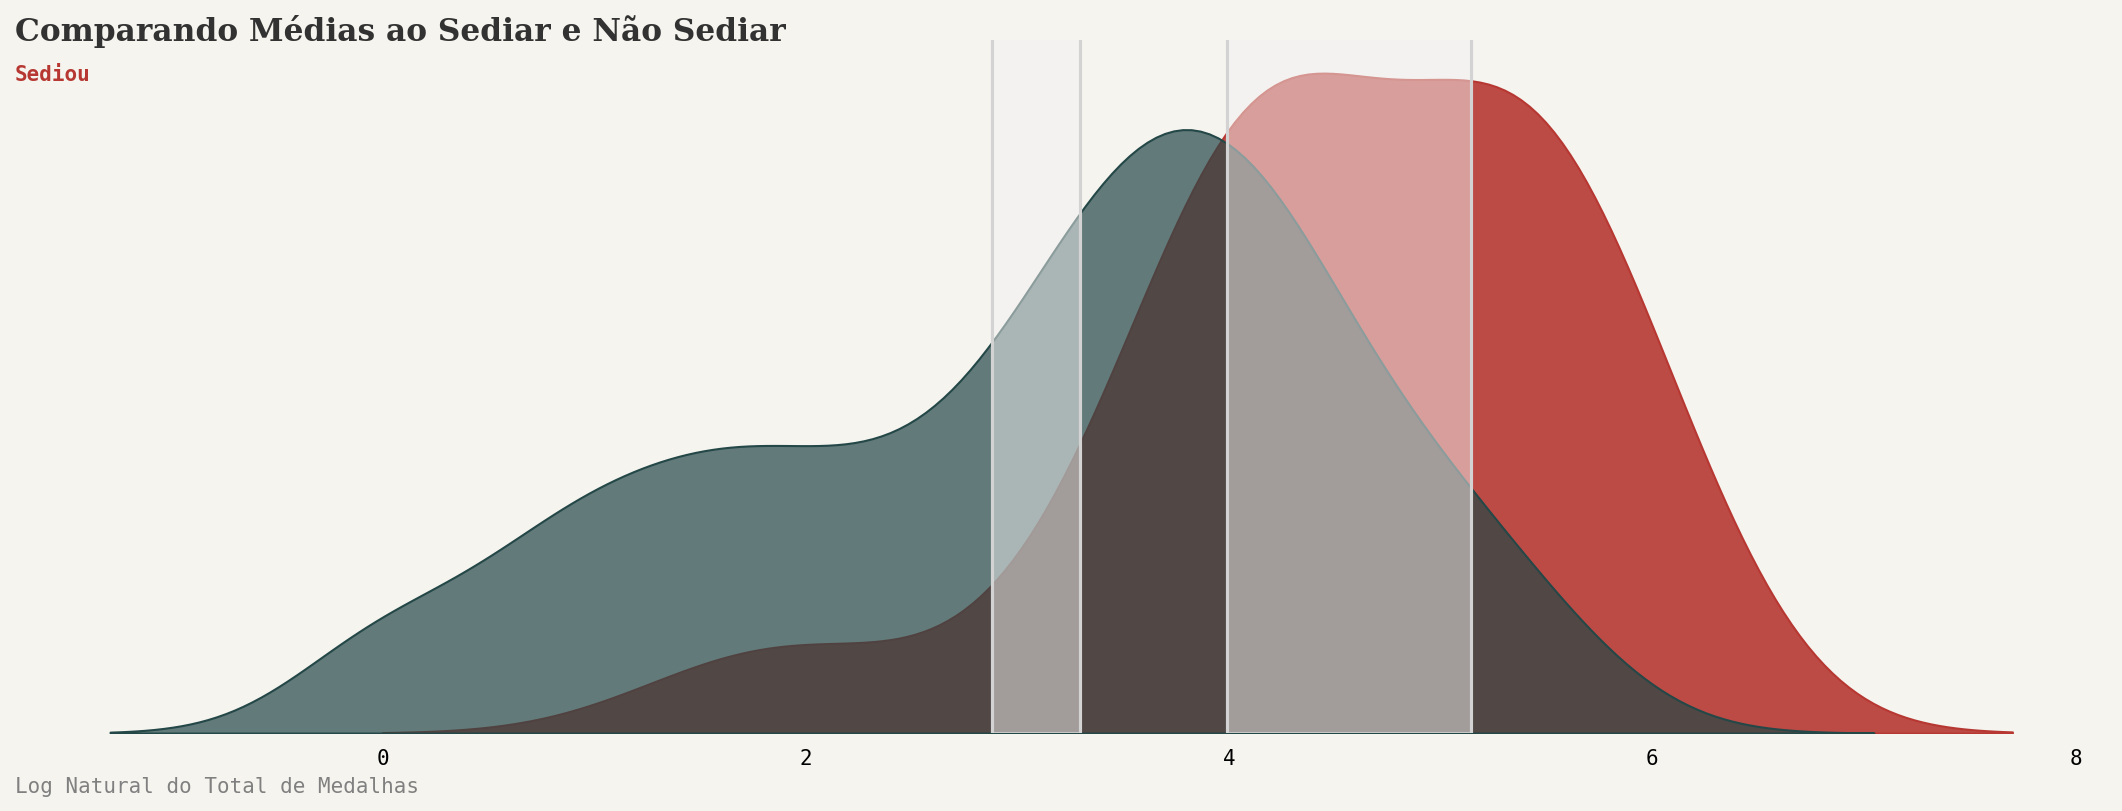

In [89]:
fig, ax = plt.subplots(1,1, figsize=(18,6), facecolor=background_color)
ax.set_facecolor(background_color)
sns.kdeplot(data=df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 1"), x='Total_Medals_NaturalLog',shade=True,color='#B73832',alpha=0.9, ax=ax)
sns.kdeplot(data=df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 0"), x='Total_Medals_NaturalLog', shade=True, color='#244747',alpha=0.7, ax=ax)

ax.axvline(color='lightgray',x=nao_sediou_media+(3*nao_sediou_std_erro))
ax.axvline(color='lightgray',x=nao_sediou_media-(3*nao_sediou_std_erro))
ax.axvspan(nao_sediou_media-(3*nao_sediou_std_erro), nao_sediou_media+(3*nao_sediou_std_erro), alpha=0.5, color='#f3f2f1')


ax.axvline(color='lightgray',x=sediou_media+(3*sediou_std_erro))
ax.axvline(color='lightgray',x=sediou_media-(3*sediou_std_erro))
ax.axvspan(sediou_media-(3*sediou_std_erro), sediou_media+(3*sediou_std_erro), alpha=0.5, color='#f3f2f1')

for s in ['top','left', 'bottom', 'right']:
    ax.spines[s].set_visible(False)

ax.set_xlabel("Log Natural do Total de Medalhas",fontfamily='monospace',loc='left',color='gray')
ax.get_yaxis().set_visible(False)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True)


x_inicial, x_final = ax.get_xlim()
y_inicial, y_final = ax.get_ylim()

ax.text(x_inicial,y_final, 'Comparando Médias ao Sediar e Não Sediar', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(x_inicial,y_final-0.02, 'Sediou', fontsize=10,fontweight='bold',color='#B73832')


plt.show()


Acima, tracei as distribuições do logaritmo natural do total médio de medalhas que as nações anfitriãs obtiveram quando foram anfitriãs e quando não foram anfitriãs.

As caixas cinza representam 3 erros padrão acima e abaixo dos valores médios. Observamos que essas áreas não se sobrepõem. Isso sugere que a probabilidade de a hospedagem não melhorar o desempenho é extremamente pequena. Na verdade, é esmagadoramente pequeno.

In [95]:
from scipy.stats import ttest_ind

# Aqui estamos comparando as amostras de medalhas naturais em países que não sediaram e países que sediaram
# A hipótese nula (H0) é que as médias das duas amostras são iguais
# A hipótese alternativa (H1) é que as médias das duas amostras são diferentes
# Comparando amostras
stat, p = ttest_ind(df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 0")['Total_Medals_NaturalLog'], df_new[df_new['region'].isin(pais_sede)].query("Is_Host == 1")['Total_Medals_NaturalLog'])
print('Estatística = %.3f, p = %.3f' % (stat, p))

# Interpretando
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falha em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')

Estatística = -5.583, p = 0.000
Distribuições diferentes (rejeitar H0)


Com base nos testes acima, parece que podemos rejeitar a hipótese nula de que ser país sede não tem impacto no desempenho.

## Conclusão

Ao longo desta análise, observamos que sediar os Jogos Olímpicos parece estar associado a um melhor desempenho dos países no quadro de medalhas. No entanto, é importante considerar que essa associação pode ser influenciada por diversos fatores, como o desenvolvimento econômico e o investimento em esportes. É relevante ressaltar que os países que sediam os Jogos Olímpicos são geralmente nações ricas e desenvolvidas, o que pode contribuir significativamente para seu desempenho esportivo. Dito isso, nossos resultados sugerem que sediar as Olimpíadas pode proporcionar uma vantagem competitiva aos países anfitriões. Essas descobertas destacam a importância de analisar os dados de forma cuidadosa e interpretar os resultados com cautela, também de se utilizar conceitos de storytelling para comunicar eficazmente as descobertas.
